In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, linregress

import os
import time
import itertools

from glove_VI.glv import *

from sklearn.model_selection import KFold

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# number of folds
n_splits = 20

# number of inner folds
n_splits_2 = 10

# range of L1 coefs
lmbdas = np.array([0., .000001, .00001, .0001, .001])

# number of training epochs
n_epochs = 200

# import file names
files = os.listdir("data/SET3_Thirdtrial/")

# fit gLV models

In [3]:
def predict_df(model, df, species):
    
    # save measured and predicted values
    exp_names = []
    pred_species = []
    pred = []
    true = []

    # pull just the community data
    test_data = process_df_glove(df, species) 

    # plot the results
    for exp, t_span, Y_m in test_data:

        # predict 
        Y_p = model.predict_point(Y_m, t_span)
        
        # set NaN to zero
        Y_p = np.nan_to_num(Y_p)
        
        ### prediction results for species that were present ###
        inds_present = Y_m[0] > 0 
        exp_names.append([exp]*sum(inds_present)*(Y_m.shape[0]-1))
        pred_species.append(np.tile(np.vstack(species)[inds_present], Y_m.shape[0]-1).T.ravel())
        true.append(Y_m[1:,inds_present].ravel())
        pred.append(Y_p[1:,inds_present].ravel())
                
    # concatenate list
    exp_names = np.concatenate(exp_names)
    pred_species = np.concatenate(pred_species)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
        
    return exp_names, pred_species, true, pred

In [4]:
def optimize_lmbda(df):
    
    # determine species names 
    species = df.columns.values[2:]

    # separate mono culture data 
    mono_dfs = []
    dfs = []
    treatments = []
    for treatment, df_i in df.groupby("Treatments"):
        # hyphen is only in community conditions
        if "-" in treatment:
            dfs.append(df_i)
            # save treatment name without the replicate identifier 
            treatments.append([treatment.split("_")[0]]*df_i.shape[0])
        else:
            mono_dfs.append(df_i)
    treatments = np.concatenate(treatments)
    unique_treatments = np.unique(treatments)
    mono_df = pd.concat(mono_dfs)
    df = pd.concat(dfs)

    # init vector of prediction performances
    performances = np.zeros(len(lmbdas))
        
    # scan range of lmbdas
    for lmbda_idx, lmbda in enumerate(lmbdas):
    
        # init kfold object
        kf = KFold(n_splits=n_splits_2, shuffle=True, random_state=21)

        # keep track of all predictions
        all_exp_names = []
        all_pred_species = []
        all_true = []
        all_pred = []

        # run Kfold 
        for kf_idx, (train_index, test_index) in enumerate(kf.split(unique_treatments)):

            # get train df
            train_inds = np.in1d(treatments, unique_treatments[train_index])
            train_df = df.iloc[train_inds].copy()
            train_df = pd.concat((mono_df, train_df))

            # average replicates in the test_df
            test_df = []
            for test_treatment in unique_treatments[test_index]:
                # pull dataframe with all replicates of same test treatment 
                treatment_inds = np.in1d(treatments, test_treatment)
                df_treatment = df.iloc[treatment_inds].copy()

                # get set of unique measurement times
                treatment_times = np.unique(df_treatment.Time.values)

                # init dataframe to store averaged values
                avg_df = pd.DataFrame()
                avg_df['Treatments'] = [test_treatment]*len(treatment_times)
                avg_df['Time'] = treatment_times

                avg_data = np.zeros([len(treatment_times), len(species)])
                for i, time in enumerate(treatment_times):
                    avg_data[i] = df_treatment.iloc[df_treatment.Time.values==time][species].mean()
                avg_df[species] = avg_data
                test_df.append(avg_df)

            # combine averaged dataframes for test dataframe
            test_df = pd.concat(test_df)

            # init model 
            model = gLV(dataframe=train_df, 
                        species=species,
                        lmbda=lmbda)

            # fit to data 
            print(f"Inner Fold {kf_idx+1}, L1: {lmbda}")
            f = model.fit_rmse(epochs=n_epochs)

            # plot fitness to data
            exp_names, pred_species, true, pred = predict_df(model, test_df, species)
            
            # append predictions 
            all_exp_names = np.append(all_exp_names, exp_names)
            all_pred_species = np.append(all_pred_species, pred_species)
            all_true = np.append(all_true, true)
            all_pred = np.append(all_pred, pred)

        # show prediction performance of individual species
        r_values = []
        for sp in species:
            sp_inds = all_pred_species == sp
            r_values.append(linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue)

        # save performance
        performances[lmbda_idx] = np.mean(r_values)
        
        # print performance and lmbda
        print(f"L1: {lmbda}, avg r: {np.mean(r_values)}")
        
    # return best lmbda
    return lmbdas[np.argmax(performances)]

Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 3.343
Epoch 10, RMSE: 0.083
Epoch 20, RMSE: 0.053
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.045
Epoch 100, RMSE: 0.045
Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.045
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.044
Epoch 160, RMSE: 0.042
Epoch 170, RMSE: 0.039
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 2, L1: 0.0
Epoch 0, RMSE: 2.187
Epoch 10, RMSE: 0.111
Epoch 20, RMSE: 0.103
Epoch 30, RMSE: 0.101
Epoch 40, RMSE: 0.094
Epoch 50, RMSE: 0.091
Epoch 60, RMSE: 0.085
Epoch 70, RMSE: 0.083
Epoch 80, RMSE: 0.066
Epoch 90, RMSE: 0.051
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.042
Epoch 130, RMSE: 0.040
Epoch 140, RMSE: 0.038
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 3

Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.033
Inner Fold 8, L1: 1e-06
Epoch 0, RMSE: 2.676
Epoch 10, RMSE: 0.104
Epoch 20, RMSE: 0.065
Epoch 30, RMSE: 0.059
Epoch 40, RMSE: 0.051
Epoch 50, RMSE: 0.045
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.033
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 1.184
Epoch 10, RMSE: 0.093
Epoch 20, RMSE: 0.054
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.043
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.032
Epoch 90, RMSE: 0.033
Epoch 10

Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 2.906
Epoch 10, RMSE: 0.184
Epoch 20, RMSE: 0.104
Epoch 30, RMSE: 0.054
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.038
Inner Fold 5, L1: 0.0001
Epoch 0, RMSE: 3.134
Epoch 10, RMSE: 0.108
Epoch 20, RMSE: 0.052
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.041
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 

Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.044
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.043
Epoch 130, RMSE: 0.044
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.043
Epoch 160, RMSE: 0.044
Epoch 170, RMSE: 0.044
Epoch 180, RMSE: 0.043
Epoch 190, RMSE: 0.044
Epoch 200, RMSE: 0.044
L1: 0.001, avg r: 0.6615728565996378
Strain CDanc, Outer Fold 1, L1: 0.001
Epoch 0, RMSE: 3.015
Epoch 10, RMSE: 0.099
Epoch 20, RMSE: 0.063
Epoch 30, RMSE: 0.057
Epoch 40, RMSE: 0.053
Epoch 50, RMSE: 0.052
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.045
Epoch 80, RMSE: 0.045
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.045
Epoch 140, RMSE: 0.045
Epoch 150, RMSE: 0.045
Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.044
Epoch 180, RMSE: 0.045
Epoch 190, RMSE: 0.044
Epoch 200, RMSE: 0.045
Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 3.796
Epoch 10, RMSE: 0.214
Epoch 20, RMSE: 0.193
Epoch 30, RMSE: 0.130
Epo

Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 6, L1: 1e-06
Epoch 0, RMSE: 3.311
Epoch 10, RMSE: 0.088
Epoch 20, RMSE: 0.074
Epoch 30, RMSE: 0.062
Epoch 40, RMSE: 0.053
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 7, L1: 1e-06
Epoch 0, RMSE: 2.640
Epoch 10, RMSE: 0.091
Epoch 20, RMSE: 0.065
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.034
Epoch 15

Epoch 10, RMSE: 0.075
Epoch 20, RMSE: 0.062
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.044
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.036
Inner Fold 3, L1: 0.0001
Epoch 0, RMSE: 2.168
Epoch 10, RMSE: 0.060
Epoch 20, RMSE: 0.050
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 3.174
Epoch 

Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.045
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.044
Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.044
Epoch 180, RMSE: 0.044
Epoch 190, RMSE: 0.045
Epoch 200, RMSE: 0.045
Inner Fold 9, L1: 0.001
Epoch 0, RMSE: 4.010
Epoch 10, RMSE: 0.123
Epoch 20, RMSE: 0.077
Epoch 30, RMSE: 0.069
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.047
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.046
Epoch 200, RMSE: 0.047
Inner Fold 10, L1: 0.001
Epoch 0, RMSE: 1.432
Epoch 10, RMSE: 0.115
Epoch 20, RMSE: 0.069
Epoch 30, RMSE: 0.062
Epoch 40, RMSE: 0.055
Epoch 50, RMSE: 0.053
Epoch 60, RMSE: 0.054
Epoch 70, RMSE: 0.053
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.047
Epoch 1

Epoch 200, RMSE: 0.034
Inner Fold 4, L1: 1e-06
Epoch 0, RMSE: 2.571
Epoch 10, RMSE: 0.140
Epoch 20, RMSE: 0.098
Epoch 30, RMSE: 0.070
Epoch 40, RMSE: 0.065
Epoch 50, RMSE: 0.061
Epoch 60, RMSE: 0.056
Epoch 70, RMSE: 0.055
Epoch 80, RMSE: 0.053
Epoch 90, RMSE: 0.053
Epoch 100, RMSE: 0.052
Epoch 110, RMSE: 0.051
Epoch 120, RMSE: 0.050
Epoch 130, RMSE: 0.049
Epoch 140, RMSE: 0.041
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.036
Inner Fold 5, L1: 1e-06
Epoch 0, RMSE: 1.558
Epoch 10, RMSE: 0.079
Epoch 20, RMSE: 0.054
Epoch 30, RMSE: 0.050
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.036
Epoch 20

Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.037
L1: 1e-05, avg r: 0.6887460193668655
Inner Fold 1, L1: 0.0001
Epoch 0, RMSE: 2.481
Epoch 10, RMSE: 0.089
Epoch 20, RMSE: 0.065
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 2, L1: 0.0001
Epoch 0, RMSE: 2.586
Epoch 10, RMSE: 0.105
Epoch 20, RMSE: 0.063
Epoch 30, RMSE: 0.049
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.040
Epoch 60, RMS

Epoch 160, RMSE: 0.047
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.047
Epoch 200, RMSE: 0.047
Inner Fold 7, L1: 0.001
Epoch 0, RMSE: 3.747
Epoch 10, RMSE: 0.106
Epoch 20, RMSE: 0.063
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.055
Epoch 50, RMSE: 0.054
Epoch 60, RMSE: 0.052
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.045
Epoch 140, RMSE: 0.045
Epoch 150, RMSE: 0.045
Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.045
Epoch 180, RMSE: 0.045
Epoch 190, RMSE: 0.045
Epoch 200, RMSE: 0.045
Inner Fold 8, L1: 0.001
Epoch 0, RMSE: 1.846
Epoch 10, RMSE: 0.080
Epoch 20, RMSE: 0.055
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.050
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.045
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.045
Epoch 100, RMSE: 0.044
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.044
Epoch 130, RMSE: 0.044
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.044
Epoch 16

Epoch 30, RMSE: 0.079
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.052
Epoch 60, RMSE: 0.048
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 3, L1: 1e-06
Epoch 0, RMSE: 4.087
Epoch 10, RMSE: 0.176
Epoch 20, RMSE: 0.059
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 4, L1: 1e-06
Epoch 0, RMSE: 3.418
Epoch 10, RMSE: 0.183
Epoch 20, RMSE: 0.145
Epoch 30

Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 9, L1: 1e-05
Epoch 0, RMSE: 3.099
Epoch 10, RMSE: 0.152
Epoch 20, RMSE: 0.140
Epoch 30, RMSE: 0.086
Epoch 40, RMSE: 0.073
Epoch 50, RMSE: 0.050
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.045
Epoch 100, RMSE: 0.040
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.036
Inner Fold 10, L1: 1e-05
Epoch 0, RMSE: 4.415
Epoch 10, RMSE: 0.091
Epoch 20, RMSE: 0.072
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.051
Epoch 50, RMSE: 0.050
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.035
Epoch 1

Inner Fold 5, L1: 0.001
Epoch 0, RMSE: 4.174
Epoch 10, RMSE: 0.071
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.055
Epoch 50, RMSE: 0.053
Epoch 60, RMSE: 0.048
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.048
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.048
Epoch 110, RMSE: 0.047
Epoch 120, RMSE: 0.047
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.048
Epoch 150, RMSE: 0.047
Epoch 160, RMSE: 0.047
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.047
Epoch 200, RMSE: 0.047
Inner Fold 6, L1: 0.001
Epoch 0, RMSE: 3.392
Epoch 10, RMSE: 0.135
Epoch 20, RMSE: 0.054
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.045
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.045
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.045
Epoch 100, RMSE: 0.044
Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.044
Epoch 140, RMSE: 0.045
Epoch 150, RMSE: 0.045
Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.045
Epoch 190, RMSE: 0.045
Epoch 200, RMSE: 0.045
Inner Fo

Epoch 100, RMSE: 0.057
Epoch 110, RMSE: 0.051
Epoch 120, RMSE: 0.048
Epoch 130, RMSE: 0.048
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.039
Epoch 160, RMSE: 0.038
Epoch 170, RMSE: 0.039
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.038
Epoch 200, RMSE: 0.038
L1: 0.0, avg r: 0.7166980974944588
Inner Fold 1, L1: 1e-06
Epoch 0, RMSE: 2.558
Epoch 10, RMSE: 0.114
Epoch 20, RMSE: 0.093
Epoch 30, RMSE: 0.054
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.042
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.034
Inner Fold 2, L1: 1e-06
Epoch 0, RMSE: 2.328
Epoch 10, RMSE: 0.095
Epoch 20, RMSE: 0.079
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0

Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.035
Inner Fold 7, L1: 1e-05
Epoch 0, RMSE: 4.190
Epoch 10, RMSE: 0.090
Epoch 20, RMSE: 0.056
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 8, L1: 1e-05
Epoch 0, RMSE: 0.950
Epoch 10, RMSE: 0.125
Epoch 20, RMSE: 0.084
Epoch 30, RMSE: 0.061
Epoch 40, RMSE: 0.055
Epoch 50, RMSE: 0.047
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 18

Epoch 40, RMSE: 0.052
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.044
Epoch 100, RMSE: 0.043
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.043
Epoch 130, RMSE: 0.043
Epoch 140, RMSE: 0.043
Epoch 150, RMSE: 0.044
Epoch 160, RMSE: 0.043
Epoch 170, RMSE: 0.043
Epoch 180, RMSE: 0.043
Epoch 190, RMSE: 0.044
Epoch 200, RMSE: 0.043
Inner Fold 4, L1: 0.001
Epoch 0, RMSE: 2.875
Epoch 10, RMSE: 0.069
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.055
Epoch 60, RMSE: 0.054
Epoch 70, RMSE: 0.048
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.047
Epoch 120, RMSE: 0.048
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.047
Epoch 150, RMSE: 0.047
Epoch 160, RMSE: 0.048
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.047
Epoch 200, RMSE: 0.047
Inner Fold 5, L1: 0.001
Epoch 0, RMSE: 0.823
Epoch 10, RMSE: 0.120
Epoch 20, RMSE: 0.068
Epoch 30, RMSE: 0.059
Epoch 40

Epoch 140, RMSE: 0.056
Epoch 150, RMSE: 0.050
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.041
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.037
Inner Fold 9, L1: 0.0
Epoch 0, RMSE: 3.359
Epoch 10, RMSE: 0.133
Epoch 20, RMSE: 0.121
Epoch 30, RMSE: 0.110
Epoch 40, RMSE: 0.097
Epoch 50, RMSE: 0.094
Epoch 60, RMSE: 0.093
Epoch 70, RMSE: 0.063
Epoch 80, RMSE: 0.049
Epoch 90, RMSE: 0.045
Epoch 100, RMSE: 0.042
Epoch 110, RMSE: 0.039
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.036
Inner Fold 10, L1: 0.0
Epoch 0, RMSE: 3.741
Epoch 10, RMSE: 0.080
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.050
Epoch 40, RMSE: 0.051
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, 

Epoch 10, RMSE: 0.089
Epoch 20, RMSE: 0.066
Epoch 30, RMSE: 0.060
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 6, L1: 1e-05
Epoch 0, RMSE: 3.545
Epoch 10, RMSE: 0.103
Epoch 20, RMSE: 0.056
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 7, L1: 1e-05
Epoch 0, RMSE: 2.913
Epoch 10

Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.047
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.048
Epoch 190, RMSE: 0.047
Epoch 200, RMSE: 0.046
Inner Fold 2, L1: 0.001
Epoch 0, RMSE: 3.249
Epoch 10, RMSE: 0.067
Epoch 20, RMSE: 0.049
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.047
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.046
Epoch 190, RMSE: 0.047
Epoch 200, RMSE: 0.046
Inner Fold 3, L1: 0.001
Epoch 0, RMSE: 3.985
Epoch 10, RMSE: 0.095
Epoch 20, RMSE: 0.074
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.045
Epoch 90

Epoch 190, RMSE: 0.048
Epoch 200, RMSE: 0.047
Inner Fold 7, L1: 0.0
Epoch 0, RMSE: 4.087
Epoch 10, RMSE: 0.218
Epoch 20, RMSE: 0.109
Epoch 30, RMSE: 0.100
Epoch 40, RMSE: 0.098
Epoch 50, RMSE: 0.080
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.041
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.036
Inner Fold 8, L1: 0.0
Epoch 0, RMSE: 2.408
Epoch 10, RMSE: 0.211
Epoch 20, RMSE: 0.123
Epoch 30, RMSE: 0.082
Epoch 40, RMSE: 0.077
Epoch 50, RMSE: 0.066
Epoch 60, RMSE: 0.066
Epoch 70, RMSE: 0.064
Epoch 80, RMSE: 0.059
Epoch 90, RMSE: 0.053
Epoch 100, RMSE: 0.051
Epoch 110, RMSE: 0.049
Epoch 120, RMSE: 0.048
Epoch 130, RMSE: 0.048
Epoch 140, RMSE: 0.047
Epoch 150, RMSE: 0.045
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, R

Epoch 60, RMSE: 0.040
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 4, L1: 1e-05
Epoch 0, RMSE: 2.744
Epoch 10, RMSE: 0.095
Epoch 20, RMSE: 0.080
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.042
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 5, L1: 1e-05
Epoch 0, RMSE: 3.063
Epoch 10, RMSE: 0.105
Epoch 20, RMSE: 0.083
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.036
Epoch 60

Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.038
Epoch 200, RMSE: 0.037
Inner Fold 10, L1: 0.0001
Epoch 0, RMSE: 0.903
Epoch 10, RMSE: 0.116
Epoch 20, RMSE: 0.065
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.038
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.038
Epoch 170, RMSE: 0.038
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.039
Epoch 200, RMSE: 0.038
L1: 0.0001, avg r: 0.668518757968926
Inner Fold 1, L1: 0.001
Epoch 0, RMSE: 3.645
Epoch 10, RMSE: 0.097
Epoch 20, RMSE: 0.061
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.055
Epoch 60, RMSE: 0.053
Epoch 70, RMSE: 0.049
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.046
Epoch 140, RMSE

Epoch 20, RMSE: 0.056
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.035
Inner Fold 6, L1: 0.0
Epoch 0, RMSE: 3.278
Epoch 10, RMSE: 0.092
Epoch 20, RMSE: 0.081
Epoch 30, RMSE: 0.073
Epoch 40, RMSE: 0.067
Epoch 50, RMSE: 0.069
Epoch 60, RMSE: 0.065
Epoch 70, RMSE: 0.063
Epoch 80, RMSE: 0.061
Epoch 90, RMSE: 0.062
Epoch 100, RMSE: 0.061
Epoch 110, RMSE: 0.057
Epoch 120, RMSE: 0.056
Epoch 130, RMSE: 0.055
Epoch 140, RMSE: 0.053
Epoch 150, RMSE: 0.055
Epoch 160, RMSE: 0.051
Epoch 170, RMSE: 0.051
Epoch 180, RMSE: 0.051
Epoch 190, RMSE: 0.050
Epoch 200, RMSE: 0.050
Inner Fold 7, L1: 0.0
Epoch 0, RMSE: 3.726
Epoch 10, RMSE: 0.094
Epoch 20, RM

Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 2, L1: 1e-05
Epoch 0, RMSE: 2.874
Epoch 10, RMSE: 0.148
Epoch 20, RMSE: 0.113
Epoch 30, RMSE: 0.062
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.040
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 3, L1: 1e-05
Epoch 0, RMSE: 3.207
Epoch 10, RMSE: 0.134
Epoch 20, RMSE: 0.074
Epoch 30, RMSE: 0.060
Epoch 40, RMSE: 0.056
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.042
Epoch 80, RMSE: 0.039
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 11

Inner Fold 8, L1: 0.0001
Epoch 0, RMSE: 3.385
Epoch 10, RMSE: 0.129
Epoch 20, RMSE: 0.070
Epoch 30, RMSE: 0.047
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.034
Inner Fold 9, L1: 0.0001
Epoch 0, RMSE: 2.306
Epoch 10, RMSE: 0.124
Epoch 20, RMSE: 0.082
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.039
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.038
Inner 

Epoch 70, RMSE: 0.040
Epoch 80, RMSE: 0.040
Epoch 90, RMSE: 0.040
Epoch 100, RMSE: 0.040
Epoch 110, RMSE: 0.039
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 4, L1: 0.0
Epoch 0, RMSE: 3.581
Epoch 10, RMSE: 0.112
Epoch 20, RMSE: 0.056
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.040
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.037
Inner Fold 5, L1: 0.0
Epoch 0, RMSE: 3.142
Epoch 10, RMSE: 0.196
Epoch 20, RMSE: 0.169
Epoch 30, RMSE: 0.119
Epoch 40, RMSE: 0.103
Epoch 50, RMSE: 0.059
Epoch 60, RMSE: 0.051
Epoch 70, RM

Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 10, L1: 1e-06
Epoch 0, RMSE: 3.974
Epoch 10, RMSE: 0.083
Epoch 20, RMSE: 0.051
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.035
L1: 1e-06, avg r: 0.6707393908789132
Inner Fold 1, L1: 1e-05
Epoch 0, RMSE: 3.357
Epoch 10, RMSE: 0.104
Epoch 20, RMSE: 0.064
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.045
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.033
Epoch 160, RMSE:

Epoch 40, RMSE: 0.042
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.038
Epoch 200, RMSE: 0.037
Inner Fold 7, L1: 0.0001
Epoch 0, RMSE: 3.165
Epoch 10, RMSE: 0.079
Epoch 20, RMSE: 0.054
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 8, L1: 0.0001
Epoch 0, RMSE: 3.007
Epoch 10, RMSE: 0.098
Epoch 20, RMSE: 0.083
Epoch 30, RMSE: 0.051
Epoch 

Epoch 120, RMSE: 0.042
Epoch 130, RMSE: 0.039
Epoch 140, RMSE: 0.039
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.037
Inner Fold 2, L1: 0.0
Epoch 0, RMSE: 2.168
Epoch 10, RMSE: 0.158
Epoch 20, RMSE: 0.144
Epoch 30, RMSE: 0.067
Epoch 40, RMSE: 0.053
Epoch 50, RMSE: 0.050
Epoch 60, RMSE: 0.049
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.039
Epoch 90, RMSE: 0.039
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.038
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.037
Inner Fold 3, L1: 0.0
Epoch 0, RMSE: 3.677
Epoch 10, RMSE: 0.138
Epoch 20, RMSE: 0.098
Epoch 30, RMSE: 0.093
Epoch 40, RMSE: 0.091
Epoch 50, RMSE: 0.090
Epoch 60, RMSE: 0.083
Epoch 70, RMSE: 0.054
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.035
Epoch 120, R

Epoch 10, RMSE: 0.121
Epoch 20, RMSE: 0.075
Epoch 30, RMSE: 0.057
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 2.826
Epoch 10, RMSE: 0.226
Epoch 20, RMSE: 0.165
Epoch 30, RMSE: 0.143
Epoch 40, RMSE: 0.116
Epoch 50, RMSE: 0.052
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.045
Epoch 80, RMSE: 0.045
Epoch 90, RMSE: 0.040
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 10, L1: 1e-06
Epoch 0, RMSE: 3.046
Epoch 1

Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.036
Inner Fold 5, L1: 0.0001
Epoch 0, RMSE: 4.198
Epoch 10, RMSE: 0.106
Epoch 20, RMSE: 0.068
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.034
Inner Fold 6, L1: 0.0001
Epoch 0, RMSE: 3.357
Epoch 10, RMSE: 0.120
Epoch 20, RMSE: 0.087
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.042
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 

Epoch 200, RMSE: 0.046
L1: 0.001, avg r: 0.6330376100092485
Strain CDanc, Outer Fold 10, L1: 0.0001
Epoch 0, RMSE: 3.932
Epoch 10, RMSE: 0.074
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.042
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 2.935
Epoch 10, RMSE: 0.105
Epoch 20, RMSE: 0.091
Epoch 30, RMSE: 0.081
Epoch 40, RMSE: 0.071
Epoch 50, RMSE: 0.047
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.041
Epoch 80, RMSE: 0.040
Epoch 90, RMSE: 0.039
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.038
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epo

Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 7, L1: 1e-06
Epoch 0, RMSE: 2.453
Epoch 10, RMSE: 0.140
Epoch 20, RMSE: 0.092
Epoch 30, RMSE: 0.071
Epoch 40, RMSE: 0.050
Epoch 50, RMSE: 0.047
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.039
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 8, L1: 1e-06
Epoch 0, RMSE: 2.727
Epoch 10, RMSE: 0.164
Epoch 20, RMSE: 0.118
Epoch 30, RMSE: 0.084
Epoch 40, RMSE: 0.058
Epoch 50, RMSE: 0.054
Epoch 60, RMSE: 0.047
Epoch 70

Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 3, L1: 0.0001
Epoch 0, RMSE: 1.972
Epoch 10, RMSE: 0.100
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.049
Epoch 40, RMSE: 0.045
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.039
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.038
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.037
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 3.966
Epoch 10, RMSE: 0.059
Epoch 20, RMSE: 0.042
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 

Epoch 30, RMSE: 0.049
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.047
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.048
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.046
Epoch 190, RMSE: 0.048
Epoch 200, RMSE: 0.046
Inner Fold 10, L1: 0.001
Epoch 0, RMSE: 1.902
Epoch 10, RMSE: 0.103
Epoch 20, RMSE: 0.066
Epoch 30, RMSE: 0.062
Epoch 40, RMSE: 0.056
Epoch 50, RMSE: 0.049
Epoch 60, RMSE: 0.048
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.047
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.047
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.046
Epoch 190, RMSE: 0.046
Epoch 200, RMSE: 0.046
L1: 0.001, avg r: 0.6532963881427254
Strain CDanc, Outer Fold 11, L1: 1e-06
Epoch 0, RMSE: 3.114

Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.032
Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
Inner Fold 5, L1: 1e-06
Epoch 0, RMSE: 3.079
Epoch 10, RMSE: 0.113
Epoch 20, RMSE: 0.103
Epoch 30, RMSE: 0.087
Epoch 40, RMSE: 0.081
Epoch 50, RMSE: 0.063
Epoch 60, RMSE: 0.042
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.033
Epoch 90, RMSE: 0.032
Epoch 100, RMSE: 0.032
Epoch 110, RMSE: 0.032
Epoch 120, RMSE: 0.032
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.031
Epoch 190, RMSE: 0.031
Epoch 200, RMSE: 0.031
Inner Fold 6, L1: 1e-06
Epoch 0, RMSE: 2.534
Epoch 10, RMSE: 0.270
Epoch 20, RMSE: 0.077
Epoch 30, RMSE: 0.054
Epoch 40, RMSE: 0.044
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 12

Epoch 10, RMSE: 0.204
Epoch 20, RMSE: 0.102
Epoch 30, RMSE: 0.050
Epoch 40, RMSE: 0.045
Epoch 50, RMSE: 0.043
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.033
Inner Fold 2, L1: 0.0001
Epoch 0, RMSE: 3.238
Epoch 10, RMSE: 0.074
Epoch 20, RMSE: 0.045
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 3, L1: 0.0001
Epoch 0, RMSE: 2.836
Epoch 

Epoch 110, RMSE: 0.045
Epoch 120, RMSE: 0.044
Epoch 130, RMSE: 0.043
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.044
Epoch 160, RMSE: 0.043
Epoch 170, RMSE: 0.043
Epoch 180, RMSE: 0.043
Epoch 190, RMSE: 0.044
Epoch 200, RMSE: 0.043
Inner Fold 8, L1: 0.001
Epoch 0, RMSE: 3.326
Epoch 10, RMSE: 0.121
Epoch 20, RMSE: 0.079
Epoch 30, RMSE: 0.059
Epoch 40, RMSE: 0.053
Epoch 50, RMSE: 0.050
Epoch 60, RMSE: 0.050
Epoch 70, RMSE: 0.049
Epoch 80, RMSE: 0.045
Epoch 90, RMSE: 0.044
Epoch 100, RMSE: 0.044
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.043
Epoch 130, RMSE: 0.046
Epoch 140, RMSE: 0.044
Epoch 150, RMSE: 0.044
Epoch 160, RMSE: 0.044
Epoch 170, RMSE: 0.044
Epoch 180, RMSE: 0.043
Epoch 190, RMSE: 0.043
Epoch 200, RMSE: 0.044
Inner Fold 9, L1: 0.001
Epoch 0, RMSE: 3.379
Epoch 10, RMSE: 0.093
Epoch 20, RMSE: 0.051
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.045
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.044
Epoch 100, RMSE: 0.044
Epoch 11

Epoch 200, RMSE: 0.035
Inner Fold 3, L1: 1e-06
Epoch 0, RMSE: 3.652
Epoch 10, RMSE: 0.090
Epoch 20, RMSE: 0.063
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.037
Inner Fold 4, L1: 1e-06
Epoch 0, RMSE: 2.514
Epoch 10, RMSE: 0.133
Epoch 20, RMSE: 0.103
Epoch 30, RMSE: 0.089
Epoch 40, RMSE: 0.071
Epoch 50, RMSE: 0.058
Epoch 60, RMSE: 0.054
Epoch 70, RMSE: 0.051
Epoch 80, RMSE: 0.050
Epoch 90, RMSE: 0.050
Epoch 100, RMSE: 0.049
Epoch 110, RMSE: 0.040
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 20

Epoch 80, RMSE: 0.041
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 10, L1: 1e-05
Epoch 0, RMSE: 3.885
Epoch 10, RMSE: 0.066
Epoch 20, RMSE: 0.050
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.035
L1: 1e-05, avg r: 0.6846892804733633
Inner Fold 1, L1: 0.0001
Epoch 0, RMSE: 2.744
Epoch 10, RMSE: 0.136
Epoch 20, RMSE: 0.093
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.037
Epoch 60, RMS

Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.046
Epoch 190, RMSE: 0.045
Epoch 200, RMSE: 0.046
Inner Fold 6, L1: 0.001
Epoch 0, RMSE: 3.720
Epoch 10, RMSE: 0.069
Epoch 20, RMSE: 0.048
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.045
Epoch 50, RMSE: 0.045
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.045
Epoch 80, RMSE: 0.045
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.046
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.046
Epoch 190, RMSE: 0.046
Epoch 200, RMSE: 0.046
Inner Fold 7, L1: 0.001
Epoch 0, RMSE: 2.257
Epoch 10, RMSE: 0.088
Epoch 20, RMSE: 0.065
Epoch 30, RMSE: 0.058
Epoch 40, RMSE: 0.050
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.048
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.048
Epoch 110, RMSE: 0.047
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.047
Epoch 16

Epoch 30, RMSE: 0.060
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 2, L1: 1e-06
Epoch 0, RMSE: 2.426
Epoch 10, RMSE: 0.169
Epoch 20, RMSE: 0.150
Epoch 30, RMSE: 0.085
Epoch 40, RMSE: 0.074
Epoch 50, RMSE: 0.049
Epoch 60, RMSE: 0.042
Epoch 70, RMSE: 0.040
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.035
Inner Fold 3, L1: 1e-06
Epoch 0, RMSE: 3.017
Epoch 10, RMSE: 0.199
Epoch 20, RMSE: 0.192
Epoch 30

Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.036
Inner Fold 8, L1: 1e-05
Epoch 0, RMSE: 3.958
Epoch 10, RMSE: 0.203
Epoch 20, RMSE: 0.050
Epoch 30, RMSE: 0.038
Epoch 40, RMSE: 0.036
Epoch 50, RMSE: 0.035
Epoch 60, RMSE: 0.034
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 9, L1: 1e-05
Epoch 0, RMSE: 1.020
Epoch 10, RMSE: 0.111
Epoch 20, RMSE: 0.078
Epoch 30, RMSE: 0.059
Epoch 40, RMSE: 0.050
Epoch 50, RMSE: 0.047
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.040
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 13

Inner Fold 4, L1: 0.001
Epoch 0, RMSE: 3.657
Epoch 10, RMSE: 0.135
Epoch 20, RMSE: 0.085
Epoch 30, RMSE: 0.058
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.048
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.047
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.046
Epoch 200, RMSE: 0.047
Inner Fold 5, L1: 0.001
Epoch 0, RMSE: 2.878
Epoch 10, RMSE: 0.076
Epoch 20, RMSE: 0.056
Epoch 30, RMSE: 0.050
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.045
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.045
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.046
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.046
Epoch 180, RMSE: 0.046
Epoch 190, RMSE: 0.046
Epoch 200, RMSE: 0.045
Inner Fo

Epoch 100, RMSE: 0.042
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 10, L1: 0.0
Epoch 0, RMSE: 3.641
Epoch 10, RMSE: 0.100
Epoch 20, RMSE: 0.053
Epoch 30, RMSE: 0.047
Epoch 40, RMSE: 0.045
Epoch 50, RMSE: 0.043
Epoch 60, RMSE: 0.042
Epoch 70, RMSE: 0.042
Epoch 80, RMSE: 0.041
Epoch 90, RMSE: 0.042
Epoch 100, RMSE: 0.041
Epoch 110, RMSE: 0.041
Epoch 120, RMSE: 0.041
Epoch 130, RMSE: 0.040
Epoch 140, RMSE: 0.039
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.038
Epoch 170, RMSE: 0.038
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.039
Epoch 200, RMSE: 0.037
L1: 0.0, avg r: 0.6061820685380448
Inner Fold 1, L1: 1e-06
Epoch 0, RMSE: 2.735
Epoch 10, RMSE: 0.145
Epoch 20, RMSE: 0.095
Epoch 30, RMSE: 0.061
Epoch 40, RMSE: 0.056
Epoch 50, RMSE: 0.052
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.

Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 6, L1: 1e-05
Epoch 0, RMSE: 3.183
Epoch 10, RMSE: 0.128
Epoch 20, RMSE: 0.103
Epoch 30, RMSE: 0.093
Epoch 40, RMSE: 0.086
Epoch 50, RMSE: 0.059
Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 7, L1: 1e-05
Epoch 0, RMSE: 3.370
Epoch 10, RMSE: 0.111
Epoch 20, RMSE: 0.088
Epoch 30, RMSE: 0.066
Epoch 40, RMSE: 0.041
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.033
Epoch 19

Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.046
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.046
Epoch 100, RMSE: 0.047
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.045
Epoch 130, RMSE: 0.045
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.045
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.045
Epoch 180, RMSE: 0.045
Epoch 190, RMSE: 0.045
Epoch 200, RMSE: 0.045
Inner Fold 3, L1: 0.001
Epoch 0, RMSE: 3.517
Epoch 10, RMSE: 0.104
Epoch 20, RMSE: 0.062
Epoch 30, RMSE: 0.054
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.047
Epoch 100, RMSE: 0.046
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.048
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.047
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.046
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.047
Epoch 200, RMSE: 0.047
Inner Fold 4, L1: 0.001
Epoch 0, RMSE: 3.378
Epoch 10, RMSE: 0.112
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.054
Epoch 50

Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.034
Inner Fold 8, L1: 0.0
Epoch 0, RMSE: 2.689
Epoch 10, RMSE: 0.122
Epoch 20, RMSE: 0.079
Epoch 30, RMSE: 0.074
Epoch 40, RMSE: 0.068
Epoch 50, RMSE: 0.064
Epoch 60, RMSE: 0.063
Epoch 70, RMSE: 0.063
Epoch 80, RMSE: 0.062
Epoch 90, RMSE: 0.059
Epoch 100, RMSE: 0.056
Epoch 110, RMSE: 0.052
Epoch 120, RMSE: 0.052
Epoch 130, RMSE: 0.051
Epoch 140, RMSE: 0.050
Epoch 150, RMSE: 0.051
Epoch 160, RMSE: 0.050
Epoch 170, RMSE: 0.050
Epoch 180, RMSE: 0.050
Epoch 190, RMSE: 0.051
Epoch 200, RMSE: 0.051
Inner Fold 9, L1: 0.0
Epoch 0, RMSE: 3.376
Epoch 10, RMSE: 0.090
Epoch 20, RMSE: 0.049
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, R

Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.034
Inner Fold 5, L1: 1e-05
Epoch 0, RMSE: 3.004
Epoch 10, RMSE: 0.181
Epoch 20, RMSE: 0.161
Epoch 30, RMSE: 0.154
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.033
Inner Fold 6, L1: 1e-05
Epoch 0, RMSE: 2.008
Epoch 10, RMSE: 0.123
Epoch 20

Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.036
L1: 0.0001, avg r: 0.6830547433211533
Inner Fold 1, L1: 0.001
Epoch 0, RMSE: 3.116
Epoch 10, RMSE: 0.128
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.051
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.044
Epoch 100, RMSE: 0.044
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.043
Epoch 130, RMSE: 0.043
Epoch 140, RMSE: 0.043
Epoch 150, RMSE: 0.044
Epoch 160, RMSE: 0.044
Epoch 170, RMSE: 0.043
Epoch 180, RMSE: 0.044
Epoch 190, RMSE: 0.044
Epoch 200, RMSE: 0.044
Inner Fold 2, L1: 0.001
Epoch 0, RMSE: 3.294
Epoch 10, RMSE: 0.124
Epoch 20, RMSE: 0.084
Epoch 30, RMSE: 0.058
Epoch 40, RMSE: 0.055
Epoch 50, RMSE: 0.053
Epoch 60, RMSE: 0.053
Epoch 70, RMSE: 0.052
Epoch 80, RMSE: 0.048
Epoch 90, RMSE: 0.046
Epoch 100, RMSE:

Epoch 200, RMSE: 0.034
Inner Fold 6, L1: 0.0
Epoch 0, RMSE: 3.944
Epoch 10, RMSE: 0.110
Epoch 20, RMSE: 0.083
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.045
Epoch 70, RMSE: 0.045
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.039
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 7, L1: 0.0
Epoch 0, RMSE: 2.155
Epoch 10, RMSE: 0.090
Epoch 20, RMSE: 0.078
Epoch 30, RMSE: 0.057
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.044
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.044
Epoch 100, RMSE: 0.043
Epoch 110, RMSE: 0.043
Epoch 120, RMSE: 0.041
Epoch 130, RMSE: 0.040
Epoch 140, RMSE: 0.042
Epoch 150, RMSE: 0.040
Epoch 160, RMSE: 0.041
Epoch 170, RMSE: 0.040
Epoch 180, RMSE: 0.040
Epoch 190, RMSE: 0.041
Epoch 200, R

Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 3, L1: 1e-05
Epoch 0, RMSE: 3.058
Epoch 10, RMSE: 0.095
Epoch 20, RMSE: 0.082
Epoch 30, RMSE: 0.066
Epoch 40, RMSE: 0.041
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.035
Inner Fold 4, L1: 1e-05
Epoch 0, RMSE: 2.799
Epoch 10, RMSE: 0.094
Epoch 20, RMSE: 0.071
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.037
Epoch 70

Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
Inner Fold 9, L1: 0.0001
Epoch 0, RMSE: 3.340
Epoch 10, RMSE: 0.172
Epoch 20, RMSE: 0.097
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.042
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 10, L1: 0.0001
Epoch 0, RMSE: 3.038
Epoch 10, RMSE: 0.126
Epoch 20, RMSE: 0.089
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.053
Epoch 50, RMSE: 0.042
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch

Epoch 30, RMSE: 0.110
Epoch 40, RMSE: 0.056
Epoch 50, RMSE: 0.045
Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.043
Epoch 80, RMSE: 0.042
Epoch 90, RMSE: 0.042
Epoch 100, RMSE: 0.041
Epoch 110, RMSE: 0.041
Epoch 120, RMSE: 0.042
Epoch 130, RMSE: 0.041
Epoch 140, RMSE: 0.041
Epoch 150, RMSE: 0.041
Epoch 160, RMSE: 0.041
Epoch 170, RMSE: 0.041
Epoch 180, RMSE: 0.041
Epoch 190, RMSE: 0.040
Epoch 200, RMSE: 0.041
Inner Fold 5, L1: 0.0
Epoch 0, RMSE: 2.899
Epoch 10, RMSE: 0.125
Epoch 20, RMSE: 0.110
Epoch 30, RMSE: 0.097
Epoch 40, RMSE: 0.086
Epoch 50, RMSE: 0.078
Epoch 60, RMSE: 0.074
Epoch 70, RMSE: 0.054
Epoch 80, RMSE: 0.043
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.035
Inner Fold 6, L1: 0.0
Epoch 0, RMSE: 2.078
Epoch 10, RMSE: 0.093
Epoch 20, RMSE: 0.076
Epoch 30, RM

Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
L1: 1e-06, avg r: 0.7069415198472897
Inner Fold 1, L1: 1e-05
Epoch 0, RMSE: 2.877
Epoch 10, RMSE: 0.087
Epoch 20, RMSE: 0.054
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.034
Inner Fold 2, L1: 1e-05
Epoch 0, RMSE: 1.806
Epoch 10, RMSE: 0.147
Epoch 20, RMSE: 0.068
Epoch 30, RMSE: 0.058
Epoch 40, RMSE: 0.051
Epoch 50, RMSE: 0.046
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 

Epoch 10, RMSE: 0.096
Epoch 20, RMSE: 0.057
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.038
Inner Fold 8, L1: 0.0001
Epoch 0, RMSE: 4.371
Epoch 10, RMSE: 0.061
Epoch 20, RMSE: 0.046
Epoch 30, RMSE: 0.039
Epoch 40, RMSE: 0.036
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
Inner Fold 9, L1: 0.0001
Epoch 0, RMSE: 2.709
Epoch 

Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.035
Inner Fold 3, L1: 0.0
Epoch 0, RMSE: 3.266
Epoch 10, RMSE: 0.130
Epoch 20, RMSE: 0.081
Epoch 30, RMSE: 0.070
Epoch 40, RMSE: 0.068
Epoch 50, RMSE: 0.067
Epoch 60, RMSE: 0.067
Epoch 70, RMSE: 0.067
Epoch 80, RMSE: 0.066
Epoch 90, RMSE: 0.067
Epoch 100, RMSE: 0.060
Epoch 110, RMSE: 0.058
Epoch 120, RMSE: 0.053
Epoch 130, RMSE: 0.052
Epoch 140, RMSE: 0.051
Epoch 150, RMSE: 0.050
Epoch 160, RMSE: 0.050
Epoch 170, RMSE: 0.047
Epoch 180, RMSE: 0.041
Epoch 190, RMSE: 0.039
Epoch 200, RMSE: 0.038
Inner Fold 4, L1: 0.0
Epoch 0, RMSE: 1.257
Epoch 10, RMSE: 0.114
Epoch 20, RMSE: 0.100
Epoch 30, RMSE: 0.090
Epoch 40, RMSE: 0.069
Epoch 50, RMSE: 0.066
Epoch 60, RMSE: 0.066
Epoch 70, RMSE: 0.061
Epoch 80, RMSE: 0.057
Epoch 90, RM

Epoch 200, RMSE: 0.033
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 2.146
Epoch 10, RMSE: 0.140
Epoch 20, RMSE: 0.067
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 10, L1: 1e-06
Epoch 0, RMSE: 3.208
Epoch 10, RMSE: 0.093
Epoch 20, RMSE: 0.078
Epoch 30, RMSE: 0.071
Epoch 40, RMSE: 0.065
Epoch 50, RMSE: 0.060
Epoch 60, RMSE: 0.057
Epoch 70, RMSE: 0.055
Epoch 80, RMSE: 0.054
Epoch 90, RMSE: 0.052
Epoch 100, RMSE: 0.045
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 2

Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.035
Inner Fold 6, L1: 0.0001
Epoch 0, RMSE: 3.959
Epoch 10, RMSE: 0.069
Epoch 20, RMSE: 0.045
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.039
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.038
Epoch 170, RMSE: 0.038
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.037
Inner Fold 7, L1: 0.0001
Epoch 0, RMSE: 2.888
Epoch 10, RMSE: 0.097
Epoch 20, RMSE: 0.051
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.039
Epoch 

Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.036
Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 1.929
Epoch 10, RMSE: 0.110
Epoch 20, RMSE: 0.095
Epoch 30, RMSE: 0.089
Epoch 40, RMSE: 0.086
Epoch 50, RMSE: 0.084
Epoch 60, RMSE: 0.074
Epoch 70, RMSE: 0.069
Epoch 80, RMSE: 0.067
Epoch 90, RMSE: 0.065
Epoch 100, RMSE: 0.064
Epoch 110, RMSE: 0.063
Epoch 120, RMSE: 0.063
Epoch 130, RMSE: 0.063
Epoch 140, RMSE: 0.063
Epoch 150, RMSE: 0.062
Epoch 160, RMSE: 0.061
Epoch 170, RMSE: 0.062
Epoch 180, RMSE: 0.062
Epoch 190, RMSE: 0.063
Epoch 200, RMSE: 0.062
Inner Fold 2, L1: 0.0
Epoch 0, RMSE: 2.910
Epoch 10, RMSE: 0.078
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.044
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.041
Epoch 70, RMSE: 0.041
Epoch 80, RMSE: 0.040
Epoch 90, RMSE: 0.039
Epoch 100, RMSE: 0.039
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.040
Epoch 130, RMSE: 0.038
Epoch 140, R

Epoch 30, RMSE: 0.039
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.035
Inner Fold 8, L1: 1e-06
Epoch 0, RMSE: 2.367
Epoch 10, RMSE: 0.118
Epoch 20, RMSE: 0.098
Epoch 30, RMSE: 0.080
Epoch 40, RMSE: 0.074
Epoch 50, RMSE: 0.066
Epoch 60, RMSE: 0.043
Epoch 70, RMSE: 0.039
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 3.644
Epoch 10, RMSE: 0.067
Epoch 20, RMSE: 0.052
Epoch 30

Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.036
Epoch 180, RMSE: 0.036
Epoch 190, RMSE: 0.036
Epoch 200, RMSE: 0.037
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 3.201
Epoch 10, RMSE: 0.148
Epoch 20, RMSE: 0.114
Epoch 30, RMSE: 0.076
Epoch 40, RMSE: 0.064
Epoch 50, RMSE: 0.042
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.038
Epoch 160, RMSE: 0.038
Epoch 170, RMSE: 0.038
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.038
Inner Fold 5, L1: 0.0001
Epoch 0, RMSE: 3.250
Epoch 10, RMSE: 0.074
Epoch 20, RMSE: 0.052
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.036
Epoch 

Epoch 10, RMSE: 0.083
Epoch 20, RMSE: 0.061
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.052
Epoch 50, RMSE: 0.048
Epoch 60, RMSE: 0.048
Epoch 70, RMSE: 0.049
Epoch 80, RMSE: 0.047
Epoch 90, RMSE: 0.048
Epoch 100, RMSE: 0.048
Epoch 110, RMSE: 0.048
Epoch 120, RMSE: 0.047
Epoch 130, RMSE: 0.048
Epoch 140, RMSE: 0.047
Epoch 150, RMSE: 0.048
Epoch 160, RMSE: 0.048
Epoch 170, RMSE: 0.048
Epoch 180, RMSE: 0.047
Epoch 190, RMSE: 0.048
Epoch 200, RMSE: 0.047
L1: 0.001, avg r: 0.6313850220427655
Strain CDanc, Outer Fold 20, L1: 0.0001
Epoch 0, RMSE: 3.683
Epoch 10, RMSE: 0.182
Epoch 20, RMSE: 0.079
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.041
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.040
Epoch 140, RMSE: 0.037
Epoch 150, RMSE: 0.037
Epoch 160, RMSE: 0.037
Epoch 170, RMSE: 0.037
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.037
Epoch 200, RMSE: 0.037


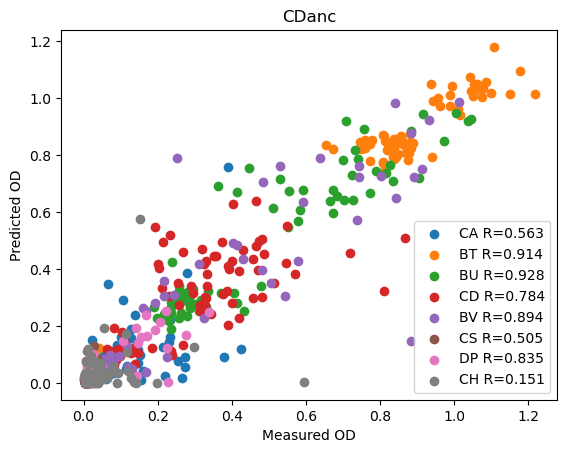

Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 3.768
Epoch 10, RMSE: 0.209
Epoch 20, RMSE: 0.145
Epoch 30, RMSE: 0.090
Epoch 40, RMSE: 0.069
Epoch 50, RMSE: 0.058
Epoch 60, RMSE: 0.031
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 2, L1: 0.0
Epoch 0, RMSE: 3.140
Epoch 10, RMSE: 0.206
Epoch 20, RMSE: 0.187
Epoch 30, RMSE: 0.180
Epoch 40, RMSE: 0.125
Epoch 50, RMSE: 0.107
Epoch 60, RMSE: 0.049
Epoch 70, RMSE: 0.033
Epoch 80, RMSE: 0.030
Epoch 90, RMSE: 0.028
Epoch 100, RMSE: 0.028
Epoch 110, RMSE: 0.028
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.027
Epoch 200, RMSE: 0.026
Inner Fold 3

Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.023
Epoch 130, RMSE: 0.023
Epoch 140, RMSE: 0.023
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.022
Inner Fold 8, L1: 1e-06
Epoch 0, RMSE: 2.948
Epoch 10, RMSE: 0.119
Epoch 20, RMSE: 0.052
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.025
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 3.310
Epoch 10, RMSE: 0.102
Epoch 20, RMSE: 0.078
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 10

Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.025
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 3.246
Epoch 10, RMSE: 0.199
Epoch 20, RMSE: 0.132
Epoch 30, RMSE: 0.085
Epoch 40, RMSE: 0.069
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.032
Epoch 70, RMSE: 0.030
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.027
Epoch 200, RMSE: 0.027
Inner Fold 5, L1: 0.0001
Epoch 0, RMSE: 4.000
Epoch 10, RMSE: 0.211
Epoch 20, RMSE: 0.122
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.032
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.029
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.028
Epoch 170, RMSE: 0.026
Epoch 

Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.032
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.030
Epoch 150, RMSE: 0.031
Epoch 160, RMSE: 0.030
Epoch 170, RMSE: 0.030
Epoch 180, RMSE: 0.030
Epoch 190, RMSE: 0.030
Epoch 200, RMSE: 0.030
L1: 0.001, avg r: 0.7237022321869453
Strain CDevo, Outer Fold 1, L1: 0.0001
Epoch 0, RMSE: 3.849
Epoch 10, RMSE: 0.154
Epoch 20, RMSE: 0.055
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.031
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.027
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.027
Epoch 200, RMSE: 0.027
Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 3.762
Epoch 10, RMSE: 0.193
Epoch 20, RMSE: 0.149
Epoch 30, RMSE: 0.063
Ep

Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 6, L1: 1e-06
Epoch 0, RMSE: 4.043
Epoch 10, RMSE: 0.542
Epoch 20, RMSE: 0.122
Epoch 30, RMSE: 0.112
Epoch 40, RMSE: 0.103
Epoch 50, RMSE: 0.083
Epoch 60, RMSE: 0.071
Epoch 70, RMSE: 0.066
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.030
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.022
Epoch 200, RMSE: 0.022
Inner Fold 7, L1: 1e-06
Epoch 0, RMSE: 3.973
Epoch 10, RMSE: 0.277
Epoch 20, RMSE: 0.137
Epoch 30, RMSE: 0.076
Epoch 40, RMSE: 0.054
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.040
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.030
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.023
Epoch 15

Epoch 10, RMSE: 0.638
Epoch 20, RMSE: 0.043
Epoch 30, RMSE: 0.035
Epoch 40, RMSE: 0.029
Epoch 50, RMSE: 0.027
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.024
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.024
Inner Fold 3, L1: 0.0001
Epoch 0, RMSE: 3.502
Epoch 10, RMSE: 0.200
Epoch 20, RMSE: 0.141
Epoch 30, RMSE: 0.090
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.033
Epoch 60, RMSE: 0.031
Epoch 70, RMSE: 0.030
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.028
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.027
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.027
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 2.553
Epoch 

Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 9, L1: 0.001
Epoch 0, RMSE: 1.692
Epoch 10, RMSE: 0.115
Epoch 20, RMSE: 0.088
Epoch 30, RMSE: 0.062
Epoch 40, RMSE: 0.050
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.032
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
Inner Fold 10, L1: 0.001
Epoch 0, RMSE: 3.217
Epoch 10, RMSE: 0.123
Epoch 20, RMSE: 0.043
Epoch 30, RMSE: 0.038
Epoch 40, RMSE: 0.035
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.033
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.033
Epoch 1

Epoch 200, RMSE: 0.025
Inner Fold 4, L1: 1e-06
Epoch 0, RMSE: 3.664
Epoch 10, RMSE: 1.208
Epoch 20, RMSE: 0.057
Epoch 30, RMSE: 0.038
Epoch 40, RMSE: 0.032
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.025
Inner Fold 5, L1: 1e-06
Epoch 0, RMSE: 3.807
Epoch 10, RMSE: 0.205
Epoch 20, RMSE: 0.166
Epoch 30, RMSE: 0.090
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 20

Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.023
Epoch 100, RMSE: 0.023
Epoch 110, RMSE: 0.023
Epoch 120, RMSE: 0.023
Epoch 130, RMSE: 0.022
Epoch 140, RMSE: 0.022
Epoch 150, RMSE: 0.022
Epoch 160, RMSE: 0.022
Epoch 170, RMSE: 0.021
Epoch 180, RMSE: 0.022
Epoch 190, RMSE: 0.022
Epoch 200, RMSE: 0.022
L1: 1e-05, avg r: 0.7963110740931731
Inner Fold 1, L1: 0.0001
Epoch 0, RMSE: 2.225
Epoch 10, RMSE: 0.081
Epoch 20, RMSE: 0.051
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.032
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 2, L1: 0.0001
Epoch 0, RMSE: 4.007
Epoch 10, RMSE: 0.165
Epoch 20, RMSE: 0.091
Epoch 30, RMSE: 0.067
Epoch 40, RMSE: 0.036
Epoch 50, RMSE: 0.030
Epoch 60, RMS

Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
Inner Fold 7, L1: 0.001
Epoch 0, RMSE: 3.689
Epoch 10, RMSE: 0.078
Epoch 20, RMSE: 0.059
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 8, L1: 0.001
Epoch 0, RMSE: 3.231
Epoch 10, RMSE: 0.170
Epoch 20, RMSE: 0.075
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.034
Epoch 16

Epoch 30, RMSE: 0.140
Epoch 40, RMSE: 0.113
Epoch 50, RMSE: 0.049
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.033
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.025
Inner Fold 3, L1: 1e-06
Epoch 0, RMSE: 3.048
Epoch 10, RMSE: 0.237
Epoch 20, RMSE: 0.184
Epoch 30, RMSE: 0.175
Epoch 40, RMSE: 0.130
Epoch 50, RMSE: 0.065
Epoch 60, RMSE: 0.041
Epoch 70, RMSE: 0.033
Epoch 80, RMSE: 0.030
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 4, L1: 1e-06
Epoch 0, RMSE: 2.713
Epoch 10, RMSE: 0.133
Epoch 20, RMSE: 0.098
Epoch 30

Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.026
Inner Fold 9, L1: 1e-05
Epoch 0, RMSE: 3.184
Epoch 10, RMSE: 0.164
Epoch 20, RMSE: 0.060
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.031
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.024
Inner Fold 10, L1: 1e-05
Epoch 0, RMSE: 3.015
Epoch 10, RMSE: 0.149
Epoch 20, RMSE: 0.133
Epoch 30, RMSE: 0.097
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.024
Epoch 90, RMSE: 0.023
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.023
Epoch 120, RMSE: 0.023
Epoch 1

Epoch 0, RMSE: 3.772
Epoch 10, RMSE: 0.146
Epoch 20, RMSE: 0.052
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.033
Inner Fold 6, L1: 0.001
Epoch 0, RMSE: 2.524
Epoch 10, RMSE: 1.211
Epoch 20, RMSE: 0.054
Epoch 30, RMSE: 0.042
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.032
Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
Inner Fold 7, L1: 0.001
Epoch 0,

Epoch 110, RMSE: 0.038
Epoch 120, RMSE: 0.038
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.036
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.035
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.035
Epoch 190, RMSE: 0.035
Epoch 200, RMSE: 0.035
L1: 0.0, avg r: 0.7271622391416781
Inner Fold 1, L1: 1e-06
Epoch 0, RMSE: 3.050
Epoch 10, RMSE: 0.071
Epoch 20, RMSE: 0.050
Epoch 30, RMSE: 0.037
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.024
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.023
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.023
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.022
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.022
Inner Fold 2, L1: 1e-06
Epoch 0, RMSE: 3.739
Epoch 10, RMSE: 0.221
Epoch 20, RMSE: 0.212
Epoch 30, RMSE: 0.077
Epoch 40, RMSE: 0.052
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.033
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.

Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 7, L1: 1e-05
Epoch 0, RMSE: 3.594
Epoch 10, RMSE: 0.101
Epoch 20, RMSE: 0.076
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.024
Inner Fold 8, L1: 1e-05
Epoch 0, RMSE: 3.471
Epoch 10, RMSE: 0.950
Epoch 20, RMSE: 0.876
Epoch 30, RMSE: 0.131
Epoch 40, RMSE: 0.067
Epoch 50, RMSE: 0.043
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.033
Epoch 80, RMSE: 0.032
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.030
Epoch 110, RMSE: 0.031
Epoch 120, RMSE: 0.030
Epoch 130, RMSE: 0.029
Epoch 140, RMSE: 0.030
Epoch 150, RMSE: 0.030
Epoch 160, RMSE: 0.030
Epoch 170, RMSE: 0.029
Epoch 180, RMSE: 0.029
Epoch 19

Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.032
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.031
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.031
Epoch 180, RMSE: 0.031
Epoch 190, RMSE: 0.031
Epoch 200, RMSE: 0.030
Inner Fold 4, L1: 0.001
Epoch 0, RMSE: 2.227
Epoch 10, RMSE: 0.131
Epoch 20, RMSE: 0.071
Epoch 30, RMSE: 0.042
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.033
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.032
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.031
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.032
Epoch 170, RMSE: 0.031
Epoch 180, RMSE: 0.031
Epoch 190, RMSE: 0.031
Epoch 200, RMSE: 0.031
Inner Fold 5, L1: 0.001
Epoch 0, RMSE: 2.989
Epoch 10, RMSE: 0.089
Epoch 20, RMSE: 0.068
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.038
Epoch 50

Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 9, L1: 0.0
Epoch 0, RMSE: 3.133
Epoch 10, RMSE: 0.091
Epoch 20, RMSE: 0.074
Epoch 30, RMSE: 0.064
Epoch 40, RMSE: 0.062
Epoch 50, RMSE: 0.060
Epoch 60, RMSE: 0.055
Epoch 70, RMSE: 0.053
Epoch 80, RMSE: 0.051
Epoch 90, RMSE: 0.051
Epoch 100, RMSE: 0.050
Epoch 110, RMSE: 0.046
Epoch 120, RMSE: 0.046
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.045
Epoch 150, RMSE: 0.045
Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.044
Epoch 180, RMSE: 0.044
Epoch 190, RMSE: 0.043
Epoch 200, RMSE: 0.038
Inner Fold 10, L1: 0.0
Epoch 0, RMSE: 3.107
Epoch 10, RMSE: 0.142
Epoch 20, RMSE: 0.056
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.037
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.037
Epoch 150, 

Epoch 20, RMSE: 0.041
Epoch 30, RMSE: 0.032
Epoch 40, RMSE: 0.028
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 6, L1: 1e-05
Epoch 0, RMSE: 2.813
Epoch 10, RMSE: 0.206
Epoch 20, RMSE: 0.117
Epoch 30, RMSE: 0.060
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.028
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 7, L1: 1e-05
Epoch 0, RMSE: 2.905
Epoch 10, RMSE: 0.133
Epoch 20

Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 2, L1: 0.001
Epoch 0, RMSE: 3.708
Epoch 10, RMSE: 0.110
Epoch 20, RMSE: 0.086
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.041
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.037
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.035
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 3, L1: 0.001
Epoch 0, RMSE: 3.106
Epoch 10, RMSE: 0.131
Epoch 20, RMSE: 0.063
Epoch 30, RMSE: 0.054
Epoch 40, RMSE: 0.041
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 10

Epoch 200, RMSE: 0.029
Inner Fold 7, L1: 0.0
Epoch 0, RMSE: 2.862
Epoch 10, RMSE: 0.144
Epoch 20, RMSE: 0.086
Epoch 30, RMSE: 0.081
Epoch 40, RMSE: 0.074
Epoch 50, RMSE: 0.070
Epoch 60, RMSE: 0.060
Epoch 70, RMSE: 0.056
Epoch 80, RMSE: 0.043
Epoch 90, RMSE: 0.042
Epoch 100, RMSE: 0.038
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.036
Epoch 130, RMSE: 0.037
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.035
Epoch 160, RMSE: 0.036
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.031
Inner Fold 8, L1: 0.0
Epoch 0, RMSE: 2.435
Epoch 10, RMSE: 0.139
Epoch 20, RMSE: 0.126
Epoch 30, RMSE: 0.115
Epoch 40, RMSE: 0.112
Epoch 50, RMSE: 0.111
Epoch 60, RMSE: 0.069
Epoch 70, RMSE: 0.052
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.043
Epoch 110, RMSE: 0.044
Epoch 120, RMSE: 0.040
Epoch 130, RMSE: 0.041
Epoch 140, RMSE: 0.040
Epoch 150, RMSE: 0.039
Epoch 160, RMSE: 0.038
Epoch 170, RMSE: 0.039
Epoch 180, RMSE: 0.038
Epoch 190, RMSE: 0.037
Epoch 200, R

Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.025
Inner Fold 4, L1: 1e-05
Epoch 0, RMSE: 2.843
Epoch 10, RMSE: 0.096
Epoch 20, RMSE: 0.069
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.025
Inner Fold 5, L1: 1e-05
Epoch 0, RMSE: 2.098
Epoch 10, RMSE: 0.131
Epoch 20, RMSE: 0.121
Epoch 30, RMSE: 0.089
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.029
Epoch 70

Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.024
Inner Fold 10, L1: 0.0001
Epoch 0, RMSE: 3.087
Epoch 10, RMSE: 0.061
Epoch 20, RMSE: 0.037
Epoch 30, RMSE: 0.032
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
L1: 0.0001, avg r: 0.7277629674139006
Inner Fold 1, L1: 0.001
Epoch 0, RMSE: 3.055
Epoch 10, RMSE: 0.096
Epoch 20, RMSE: 0.071
Epoch 30, RMSE: 0.049
Epoch 40, RMSE: 0.042
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMS

Epoch 30, RMSE: 0.095
Epoch 40, RMSE: 0.083
Epoch 50, RMSE: 0.075
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.032
Epoch 80, RMSE: 0.029
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.024
Inner Fold 6, L1: 0.0
Epoch 0, RMSE: 3.422
Epoch 10, RMSE: 0.181
Epoch 20, RMSE: 0.139
Epoch 30, RMSE: 0.130
Epoch 40, RMSE: 0.118
Epoch 50, RMSE: 0.113
Epoch 60, RMSE: 0.102
Epoch 70, RMSE: 0.096
Epoch 80, RMSE: 0.095
Epoch 90, RMSE: 0.094
Epoch 100, RMSE: 0.091
Epoch 110, RMSE: 0.049
Epoch 120, RMSE: 0.039
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.031
Epoch 150, RMSE: 0.029
Epoch 160, RMSE: 0.028
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.027
Epoch 200, RMSE: 0.025
Inner Fold 7, L1: 0.0
Epoch 0, RMSE: 3.630
Epoch 10, RMSE: 0.097
Epoch 20, RMSE: 0.074
Epoch 30, RM

Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.022
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 2, L1: 1e-05
Epoch 0, RMSE: 2.778
Epoch 10, RMSE: 0.155
Epoch 20, RMSE: 0.129
Epoch 30, RMSE: 0.055
Epoch 40, RMSE: 0.034
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.024
Inner Fold 3, L1: 1e-05
Epoch 0, RMSE: 2.308
Epoch 10, RMSE: 0.106
Epoch 20, RMSE: 0.076
Epoch 30, RMSE: 0.071
Epoch 40, RMSE: 0.064
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.041
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 12

Epoch 10, RMSE: 0.248
Epoch 20, RMSE: 0.173
Epoch 30, RMSE: 0.111
Epoch 40, RMSE: 0.069
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.030
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 9, L1: 0.0001
Epoch 0, RMSE: 1.575
Epoch 10, RMSE: 0.199
Epoch 20, RMSE: 0.118
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.032
Epoch 50, RMSE: 0.030
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.028
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.027
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.029
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.029
Epoch 190, RMSE: 0.027
Epoch 200, RMSE: 0.026
Inner Fold 10, L1: 0.0001
Epoch 0, RMSE: 2.254
Epoch

Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 4, L1: 0.0
Epoch 0, RMSE: 3.700
Epoch 10, RMSE: 0.189
Epoch 20, RMSE: 0.180
Epoch 30, RMSE: 0.170
Epoch 40, RMSE: 0.170
Epoch 50, RMSE: 0.144
Epoch 60, RMSE: 0.132
Epoch 70, RMSE: 0.120
Epoch 80, RMSE: 0.113
Epoch 90, RMSE: 0.110
Epoch 100, RMSE: 0.106
Epoch 110, RMSE: 0.105
Epoch 120, RMSE: 0.104
Epoch 130, RMSE: 0.102
Epoch 140, RMSE: 0.100
Epoch 150, RMSE: 0.097
Epoch 160, RMSE: 0.092
Epoch 170, RMSE: 0.089
Epoch 180, RMSE: 0.037
Epoch 190, RMSE: 0.030
Epoch 200, RMSE: 0.027
Inner Fold 5, L1: 0.0
Epoch 0, RMSE: 2.237
Epoch 10, RMSE: 0.106
Epoch 20, RMSE: 0.089
Epoch 30, RMSE: 0.050
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RM

Epoch 200, RMSE: 0.024
Inner Fold 10, L1: 1e-06
Epoch 0, RMSE: 3.484
Epoch 10, RMSE: 0.096
Epoch 20, RMSE: 0.078
Epoch 30, RMSE: 0.054
Epoch 40, RMSE: 0.035
Epoch 50, RMSE: 0.032
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
L1: 1e-06, avg r: 0.8478392236886565
Inner Fold 1, L1: 1e-05
Epoch 0, RMSE: 3.648
Epoch 10, RMSE: 0.154
Epoch 20, RMSE: 0.079
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE:

Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.028
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 7, L1: 0.0001
Epoch 0, RMSE: 2.197
Epoch 10, RMSE: 0.144
Epoch 20, RMSE: 0.116
Epoch 30, RMSE: 0.049
Epoch 40, RMSE: 0.036
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.029
Epoch 80, RMSE: 0.029
Epoch 90, RMSE: 0.028
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 8, L1: 0.0001
Epoch 0, RMSE: 2.167
Epoch 10, RMSE: 0.119
Epoch 20, RMSE: 0.046
Epoch 30, RMSE: 0.036
Epoch 40, RMSE: 0.028
Epoch 50, RMSE: 0.027
Epoch 

Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 2, L1: 0.0
Epoch 0, RMSE: 2.859
Epoch 10, RMSE: 0.113
Epoch 20, RMSE: 0.091
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.044
Epoch 60, RMSE: 0.044
Epoch 70, RMSE: 0.042
Epoch 80, RMSE: 0.041
Epoch 90, RMSE: 0.040
Epoch 100, RMSE: 0.040
Epoch 110, RMSE: 0.040
Epoch 120, RMSE: 0.039
Epoch 130, RMSE: 0.038
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.029
Epoch 180, RMSE: 0.030
Epoch 190, RMSE: 0.028
Epoch 200, RMSE: 0.027
Inner Fold 3, L1: 0.0
Epoch 0, RMSE: 2.849
Epoch 10, RMSE: 0.155
Epoch 20, RMSE: 0.150
Epoch 30, RMSE: 0.169
Epoch 40, RMSE: 0.166
Epoch 50, RMSE: 0.165
Epoch 60, RMSE: 0.138
Epoch 70, RMSE: 0.134
Epoch 80, RMSE: 0.135
Epoch 90, RMSE: 0.130
Epoch 100, RMSE: 0.128
Epoch 110, RMSE: 0.124
Epoch 120, RMSE: 0.120
Epoch 130, RMSE: 0.121
Epoch 140, R

Epoch 30, RMSE: 0.119
Epoch 40, RMSE: 0.081
Epoch 50, RMSE: 0.077
Epoch 60, RMSE: 0.060
Epoch 70, RMSE: 0.033
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.025
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 2.723
Epoch 10, RMSE: 0.168
Epoch 20, RMSE: 0.069
Epoch 30, RMSE: 0.047
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.027
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.024
Epoch 90, RMSE: 0.024
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.023
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 10, L1: 1e-06
Epoch 0, RMSE: 0.842
Epoch 10, RMSE: 0.137
Epoch 20, RMSE: 0.109
Epoch 3

Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 5, L1: 0.0001
Epoch 0, RMSE: 3.469
Epoch 10, RMSE: 0.143
Epoch 20, RMSE: 0.127
Epoch 30, RMSE: 0.078
Epoch 40, RMSE: 0.064
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 6, L1: 0.0001
Epoch 0, RMSE: 2.414
Epoch 10, RMSE: 0.083
Epoch 20, RMSE: 0.045
Epoch 30, RMSE: 0.036
Epoch 40, RMSE: 0.028
Epoch 50, RMSE: 0.026
Epoch 60, RMSE: 0.025
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.028
Epoch 100, RMSE: 0.025
Epoch 

Epoch 0, RMSE: 3.498
Epoch 10, RMSE: 0.126
Epoch 20, RMSE: 0.094
Epoch 30, RMSE: 0.082
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.032
Epoch 60, RMSE: 0.030
Epoch 70, RMSE: 0.029
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.027
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 3.470
Epoch 10, RMSE: 0.623
Epoch 20, RMSE: 0.231
Epoch 30, RMSE: 0.195
Epoch 40, RMSE: 0.129
Epoch 50, RMSE: 0.109
Epoch 60, RMSE: 0.061
Epoch 70, RMSE: 0.032
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.023
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 2, L1: 0.0
Epoch 0, RMS

Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.024
Inner Fold 7, L1: 1e-06
Epoch 0, RMSE: 3.261
Epoch 10, RMSE: 0.123
Epoch 20, RMSE: 0.087
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.032
Epoch 60, RMSE: 0.031
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.029
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 8, L1: 1e-06
Epoch 0, RMSE: 2.986
Epoch 10, RMSE: 0.112
Epoch 20, RMSE: 0.050
Epoch 30, RMSE: 0.035
Epoch 40, RMSE: 0.033
Epoch 50, RMSE: 0.030
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 11

Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 3, L1: 0.0001
Epoch 0, RMSE: 2.041
Epoch 10, RMSE: 0.129
Epoch 20, RMSE: 0.073
Epoch 30, RMSE: 0.051
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.030
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.029
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 3.781
Epoch 10, RMSE: 0.175
Epoch 20, RMSE: 0.045
Epoch 30, RMSE: 0.034
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.025
Epoch 

Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.034
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.033
Inner Fold 10, L1: 0.001
Epoch 0, RMSE: 3.386
Epoch 10, RMSE: 0.072
Epoch 20, RMSE: 0.045
Epoch 30, RMSE: 0.038
Epoch 40, RMSE: 0.035
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.033
Epoch 70, RMSE: 0.033
Epoch 80, RMSE: 0.032
Epoch 90, RMSE: 0.032
Epoch 100, RMSE: 0.032
Epoch 110, RMSE: 0.032
Epoch 120, RMSE: 0.032
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.031
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
L1: 0.001, avg r: 0.7110036658701431
Strain CDevo, Outer Fold 11, L1: 1e-05
Epoch 0, RMSE: 3.572
Epoch 10, RMSE: 0.197
Epoch 20, RMSE: 0.191
Epoch 30, RMSE: 0.187
Epoch 40, RMSE: 0.116

Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 5, L1: 1e-06
Epoch 0, RMSE: 3.764
Epoch 10, RMSE: 0.166
Epoch 20, RMSE: 0.130
Epoch 30, RMSE: 0.094
Epoch 40, RMSE: 0.072
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.030
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.023
Epoch 140, RMSE: 0.023
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 6, L1: 1e-06
Epoch 0, RMSE: 1.807
Epoch 10, RMSE: 0.130
Epoch 20, RMSE: 0.060
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.024
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 16

Epoch 20, RMSE: 0.061
Epoch 30, RMSE: 0.044
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.024
Inner Fold 2, L1: 0.0001
Epoch 0, RMSE: 3.491
Epoch 10, RMSE: 0.107
Epoch 20, RMSE: 0.046
Epoch 30, RMSE: 0.034
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.027
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.027
Inner Fold 3, L1: 0.0001
Epoch 0, RMSE: 2.175
Epoch 10, RMSE: 0.090
Epoch 

Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.034
Inner Fold 8, L1: 0.001
Epoch 0, RMSE: 3.622
Epoch 10, RMSE: 0.334
Epoch 20, RMSE: 0.059
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.034
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 9, L1: 0.001
Epoch 0, RMSE: 3.690
Epoch 10, RMSE: 0.146
Epoch 20, RMSE: 0.045
Epoch 30, RMSE: 0.037
Epoch 40, RMSE: 0.036
Epoch 50, RMSE: 0.035
Epoch 60, RMSE: 0.034
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.034
Epoch 100, RMSE: 0.032
Epoch 110, RMSE: 0.034
Epoch 12

Inner Fold 3, L1: 1e-06
Epoch 0, RMSE: 3.786
Epoch 10, RMSE: 0.071
Epoch 20, RMSE: 0.048
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.035
Epoch 50, RMSE: 0.030
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 4, L1: 1e-06
Epoch 0, RMSE: 3.757
Epoch 10, RMSE: 0.357
Epoch 20, RMSE: 0.172
Epoch 30, RMSE: 0.113
Epoch 40, RMSE: 0.098
Epoch 50, RMSE: 0.086
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.031
Epoch 80, RMSE: 0.029
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fo

Epoch 90, RMSE: 0.028
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.027
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.025
Inner Fold 10, L1: 1e-05
Epoch 0, RMSE: 3.866
Epoch 10, RMSE: 0.068
Epoch 20, RMSE: 0.041
Epoch 30, RMSE: 0.036
Epoch 40, RMSE: 0.033
Epoch 50, RMSE: 0.030
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.023
Epoch 140, RMSE: 0.023
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
L1: 1e-05, avg r: 0.748176127657055
Inner Fold 1, L1: 0.0001
Epoch 0, RMSE: 4.096
Epoch 10, RMSE: 0.177
Epoch 20, RMSE: 0.058
Epoch 30, RMSE: 0.035
Epoch 40, RMSE: 0.031
Epoch 50, RMSE: 0.028
Epoch 60, RMSE: 0.027
Epoch 70, RMSE

Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 6, L1: 0.001
Epoch 0, RMSE: 1.236
Epoch 10, RMSE: 0.146
Epoch 20, RMSE: 0.087
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.049
Epoch 50, RMSE: 0.042
Epoch 60, RMSE: 0.039
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.038
Epoch 90, RMSE: 0.038
Epoch 100, RMSE: 0.037
Epoch 110, RMSE: 0.036
Epoch 120, RMSE: 0.037
Epoch 130, RMSE: 0.036
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.034
Epoch 200, RMSE: 0.034
Inner Fold 7, L1: 0.001
Epoch 0, RMSE: 4.099
Epoch 10, RMSE: 0.105
Epoch 20, RMSE: 0.053
Epoch 30, RMSE: 0.047
Epoch 40, RMSE: 0.044
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.036
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.035
Epoch 130, RMSE: 0.035
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.036
Epoch 160, RMSE: 0.035
Epoch 17

Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.033
Epoch 70, RMSE: 0.031
Epoch 80, RMSE: 0.029
Epoch 90, RMSE: 0.029
Epoch 100, RMSE: 0.028
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.022
Inner Fold 2, L1: 1e-06
Epoch 0, RMSE: 2.637
Epoch 10, RMSE: 0.171
Epoch 20, RMSE: 0.084
Epoch 30, RMSE: 0.076
Epoch 40, RMSE: 0.068
Epoch 50, RMSE: 0.058
Epoch 60, RMSE: 0.053
Epoch 70, RMSE: 0.047
Epoch 80, RMSE: 0.046
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.028
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 3, L1: 1e-06
Epoch 0, RMSE: 2.393
Epoch 10, RMSE: 0.129
Epoch 20, RMSE: 0.119
Epoch 30, RMSE: 0.110
Epoch 40

Epoch 140, RMSE: 0.027
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 8, L1: 1e-05
Epoch 0, RMSE: 3.344
Epoch 10, RMSE: 0.231
Epoch 20, RMSE: 0.150
Epoch 30, RMSE: 0.110
Epoch 40, RMSE: 0.067
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.030
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.025
Inner Fold 9, L1: 1e-05
Epoch 0, RMSE: 3.694
Epoch 10, RMSE: 0.094
Epoch 20, RMSE: 0.059
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.044
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.029
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 14

Epoch 0, RMSE: 4.150
Epoch 10, RMSE: 0.173
Epoch 20, RMSE: 0.074
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.038
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.034
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.034
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 5, L1: 0.001
Epoch 0, RMSE: 3.225
Epoch 10, RMSE: 0.202
Epoch 20, RMSE: 0.142
Epoch 30, RMSE: 0.077
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.039
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.034
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.033
Inner Fold 6, L1: 0.001
Epoch 0,

Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.028
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.028
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.025
Inner Fold 10, L1: 0.0
Epoch 0, RMSE: 2.060
Epoch 10, RMSE: 0.087
Epoch 20, RMSE: 0.080
Epoch 30, RMSE: 0.076
Epoch 40, RMSE: 0.070
Epoch 50, RMSE: 0.067
Epoch 60, RMSE: 0.067
Epoch 70, RMSE: 0.066
Epoch 80, RMSE: 0.065
Epoch 90, RMSE: 0.065
Epoch 100, RMSE: 0.065
Epoch 110, RMSE: 0.066
Epoch 120, RMSE: 0.065
Epoch 130, RMSE: 0.064
Epoch 140, RMSE: 0.064
Epoch 150, RMSE: 0.064
Epoch 160, RMSE: 0.063
Epoch 170, RMSE: 0.060
Epoch 180, RMSE: 0.056
Epoch 190, RMSE: 0.051
Epoch 200, RMSE: 0.050
L1: 0.0, avg r: 0.5704250783277665
Inner Fold 1, L1: 1e-06
Epoch 0, RMSE: 2.766
Epoch 10, RMSE: 0.178
Epoch 20, RMSE: 0.114
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.029
Epoch 50, RMSE: 0.027
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.024
Epoch 90, RMSE: 0.0

Epoch 200, RMSE: 0.027
Inner Fold 6, L1: 1e-05
Epoch 0, RMSE: 2.667
Epoch 10, RMSE: 0.177
Epoch 20, RMSE: 0.105
Epoch 30, RMSE: 0.091
Epoch 40, RMSE: 0.076
Epoch 50, RMSE: 0.033
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
Inner Fold 7, L1: 1e-05
Epoch 0, RMSE: 3.320
Epoch 10, RMSE: 0.124
Epoch 20, RMSE: 0.062
Epoch 30, RMSE: 0.053
Epoch 40, RMSE: 0.047
Epoch 50, RMSE: 0.035
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.027
Epoch 190, RMSE: 0.026
Epoch 20

Epoch 60, RMSE: 0.036
Epoch 70, RMSE: 0.035
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.032
Epoch 160, RMSE: 0.032
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.033
Epoch 200, RMSE: 0.032
Inner Fold 3, L1: 0.001
Epoch 0, RMSE: 2.500
Epoch 10, RMSE: 0.150
Epoch 20, RMSE: 0.094
Epoch 30, RMSE: 0.077
Epoch 40, RMSE: 0.048
Epoch 50, RMSE: 0.040
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.035
Epoch 100, RMSE: 0.035
Epoch 110, RMSE: 0.035
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.034
Epoch 140, RMSE: 0.034
Epoch 150, RMSE: 0.034
Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.033
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.033
Inner Fold 4, L1: 0.001
Epoch 0, RMSE: 3.022
Epoch 10, RMSE: 0.258
Epoch 20, RMSE: 0.126
Epoch 30, RMSE: 0.063
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.038
Epoch 60

Epoch 160, RMSE: 0.033
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.031
Epoch 200, RMSE: 0.031
Inner Fold 8, L1: 0.0
Epoch 0, RMSE: 3.214
Epoch 10, RMSE: 0.146
Epoch 20, RMSE: 0.094
Epoch 30, RMSE: 0.067
Epoch 40, RMSE: 0.058
Epoch 50, RMSE: 0.050
Epoch 60, RMSE: 0.047
Epoch 70, RMSE: 0.046
Epoch 80, RMSE: 0.045
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.032
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.024
Inner Fold 9, L1: 0.0
Epoch 0, RMSE: 3.397
Epoch 10, RMSE: 0.262
Epoch 20, RMSE: 0.137
Epoch 30, RMSE: 0.075
Epoch 40, RMSE: 0.050
Epoch 50, RMSE: 0.036
Epoch 60, RMSE: 0.034
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.031
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.026
Epoch 160, R

Epoch 30, RMSE: 0.035
Epoch 40, RMSE: 0.031
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.029
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 5, L1: 1e-05
Epoch 0, RMSE: 3.469
Epoch 10, RMSE: 0.181
Epoch 20, RMSE: 0.175
Epoch 30, RMSE: 0.158
Epoch 40, RMSE: 0.084
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 6, L1: 1e-05
Epoch 0, RMSE: 1.901
Epoch 10, RMSE: 0.148
Epoch 20, RMSE: 0.096
Epoch 30

Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.025
L1: 0.0001, avg r: 0.7449121655074726
Inner Fold 1, L1: 0.001
Epoch 0, RMSE: 3.376
Epoch 10, RMSE: 0.126
Epoch 20, RMSE: 0.064
Epoch 30, RMSE: 0.050
Epoch 40, RMSE: 0.040
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.038
Epoch 70, RMSE: 0.036
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.037
Epoch 100, RMSE: 0.034
Epoch 110, RMSE: 0.033
Epoch 120, RMSE: 0.033
Epoch 130, RMSE: 0.033
Epoch 140, RMSE: 0.033
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.032
Epoch 170, RMSE: 0.033
Epoch 180, RMSE: 0.032
Epoch 190, RMSE: 0.032
Epoch 200, RMSE: 0.032
Inner Fold 2, L1: 0.001
Epoch 0, RMSE: 4.401
Epoch 10, RMSE: 0.073
Epoch 20, RMSE: 0.052
Epoch 30, RMSE: 0.046
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.038
Epoch 60, RMSE: 0.037
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.036
Epoch 90, RMSE: 0.036
Epoch 100, RMSE: 0.035
Epoch 110, RMSE:

Inner Fold 6, L1: 0.0
Epoch 0, RMSE: 2.843
Epoch 10, RMSE: 0.094
Epoch 20, RMSE: 0.047
Epoch 30, RMSE: 0.034
Epoch 40, RMSE: 0.031
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 7, L1: 0.0
Epoch 0, RMSE: 1.741
Epoch 10, RMSE: 0.181
Epoch 20, RMSE: 0.161
Epoch 30, RMSE: 0.129
Epoch 40, RMSE: 0.104
Epoch 50, RMSE: 0.097
Epoch 60, RMSE: 0.090
Epoch 70, RMSE: 0.086
Epoch 80, RMSE: 0.085
Epoch 90, RMSE: 0.084
Epoch 100, RMSE: 0.083
Epoch 110, RMSE: 0.075
Epoch 120, RMSE: 0.047
Epoch 130, RMSE: 0.039
Epoch 140, RMSE: 0.035
Epoch 150, RMSE: 0.033
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.030
Epoch 180, RMSE: 0.030
Epoch 190, RMSE: 0.029
Epoch 200, RMSE: 0.025
Inner Fold 8

Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 3, L1: 1e-05
Epoch 0, RMSE: 3.009
Epoch 10, RMSE: 0.141
Epoch 20, RMSE: 0.119
Epoch 30, RMSE: 0.095
Epoch 40, RMSE: 0.078
Epoch 50, RMSE: 0.062
Epoch 60, RMSE: 0.032
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 4, L1: 1e-05
Epoch 0, RMSE: 3.461
Epoch 10, RMSE: 0.090
Epoch 20, RMSE: 0.061
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.033
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.026
Epoch 80

Epoch 180, RMSE: 0.027
Epoch 190, RMSE: 0.029
Epoch 200, RMSE: 0.028
Inner Fold 9, L1: 0.0001
Epoch 0, RMSE: 3.198
Epoch 10, RMSE: 0.107
Epoch 20, RMSE: 0.085
Epoch 30, RMSE: 0.073
Epoch 40, RMSE: 0.043
Epoch 50, RMSE: 0.033
Epoch 60, RMSE: 0.030
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.027
Inner Fold 10, L1: 0.0001
Epoch 0, RMSE: 1.971
Epoch 10, RMSE: 0.148
Epoch 20, RMSE: 0.085
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.035
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.025
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.025
Epoch

Epoch 40, RMSE: 0.095
Epoch 50, RMSE: 0.090
Epoch 60, RMSE: 0.088
Epoch 70, RMSE: 0.087
Epoch 80, RMSE: 0.086
Epoch 90, RMSE: 0.086
Epoch 100, RMSE: 0.084
Epoch 110, RMSE: 0.084
Epoch 120, RMSE: 0.085
Epoch 130, RMSE: 0.084
Epoch 140, RMSE: 0.083
Epoch 150, RMSE: 0.083
Epoch 160, RMSE: 0.081
Epoch 170, RMSE: 0.082
Epoch 180, RMSE: 0.081
Epoch 190, RMSE: 0.080
Epoch 200, RMSE: 0.077
Inner Fold 5, L1: 0.0
Epoch 0, RMSE: 3.692
Epoch 10, RMSE: 0.068
Epoch 20, RMSE: 0.051
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.042
Epoch 50, RMSE: 0.037
Epoch 60, RMSE: 0.035
Epoch 70, RMSE: 0.034
Epoch 80, RMSE: 0.033
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.033
Epoch 110, RMSE: 0.031
Epoch 120, RMSE: 0.030
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.030
Epoch 150, RMSE: 0.030
Epoch 160, RMSE: 0.030
Epoch 170, RMSE: 0.028
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.024
Inner Fold 6, L1: 0.0
Epoch 0, RMSE: 2.721
Epoch 10, RMSE: 0.070
Epoch 20, RMSE: 0.051
Epoch 30, RMSE: 0.038
Epoch 40, RM

Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
L1: 1e-06, avg r: 0.7876114705450847
Inner Fold 1, L1: 1e-05
Epoch 0, RMSE: 3.127
Epoch 10, RMSE: 0.101
Epoch 20, RMSE: 0.062
Epoch 30, RMSE: 0.048
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.034
Epoch 60, RMSE: 0.033
Epoch 70, RMSE: 0.031
Epoch 80, RMSE: 0.028
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.028
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 2, L1: 1e-05
Epoch 0, RMSE: 2.089
Epoch 10, RMSE: 0.114
Epoch 20, RMSE: 0.055
Epoch 30, RMSE: 0.042
Epoch 40, RMSE: 0.034
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.029
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.028
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 

Epoch 10, RMSE: 0.088
Epoch 20, RMSE: 0.052
Epoch 30, RMSE: 0.043
Epoch 40, RMSE: 0.034
Epoch 50, RMSE: 0.030
Epoch 60, RMSE: 0.029
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.027
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.029
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 8, L1: 0.0001
Epoch 0, RMSE: 3.555
Epoch 10, RMSE: 0.103
Epoch 20, RMSE: 0.061
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.032
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.027
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 9, L1: 0.0001
Epoch 0, RMSE: 2.071
Epoch 

Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.023
Epoch 130, RMSE: 0.023
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.023
Epoch 170, RMSE: 0.023
Epoch 180, RMSE: 0.022
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.023
Inner Fold 3, L1: 0.0
Epoch 0, RMSE: 3.038
Epoch 10, RMSE: 0.176
Epoch 20, RMSE: 0.142
Epoch 30, RMSE: 0.137
Epoch 40, RMSE: 0.123
Epoch 50, RMSE: 0.121
Epoch 60, RMSE: 0.120
Epoch 70, RMSE: 0.115
Epoch 80, RMSE: 0.104
Epoch 90, RMSE: 0.099
Epoch 100, RMSE: 0.075
Epoch 110, RMSE: 0.054
Epoch 120, RMSE: 0.049
Epoch 130, RMSE: 0.047
Epoch 140, RMSE: 0.046
Epoch 150, RMSE: 0.046
Epoch 160, RMSE: 0.045
Epoch 170, RMSE: 0.045
Epoch 180, RMSE: 0.044
Epoch 190, RMSE: 0.044
Epoch 200, RMSE: 0.044
Inner Fold 4, L1: 0.0
Epoch 0, RMSE: 4.021
Epoch 10, RMSE: 0.128
Epoch 20, RMSE: 0.069
Epoch 30, RMSE: 0.066
Epoch 40, RMSE: 0.064
Epoch 50, RMSE: 0.063
Epoch 60, RMSE: 0.061
Epoch 70, RMSE: 0.062
Epoch 80, RMSE: 0.057
Epoch 90, RM

Epoch 200, RMSE: 0.024
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 1.747
Epoch 10, RMSE: 0.217
Epoch 20, RMSE: 0.204
Epoch 30, RMSE: 0.140
Epoch 40, RMSE: 0.122
Epoch 50, RMSE: 0.059
Epoch 60, RMSE: 0.041
Epoch 70, RMSE: 0.038
Epoch 80, RMSE: 0.035
Epoch 90, RMSE: 0.032
Epoch 100, RMSE: 0.032
Epoch 110, RMSE: 0.032
Epoch 120, RMSE: 0.034
Epoch 130, RMSE: 0.031
Epoch 140, RMSE: 0.031
Epoch 150, RMSE: 0.031
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.031
Epoch 180, RMSE: 0.031
Epoch 190, RMSE: 0.031
Epoch 200, RMSE: 0.031
Inner Fold 10, L1: 1e-06
Epoch 0, RMSE: 3.130
Epoch 10, RMSE: 0.105
Epoch 20, RMSE: 0.069
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.035
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.026
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.025
Epoch 2

Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.027
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.026
Epoch 100, RMSE: 0.026
Epoch 110, RMSE: 0.028
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.026
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.027
Epoch 160, RMSE: 0.026
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.026
Inner Fold 6, L1: 0.0001
Epoch 0, RMSE: 1.754
Epoch 10, RMSE: 0.095
Epoch 20, RMSE: 0.066
Epoch 30, RMSE: 0.045
Epoch 40, RMSE: 0.037
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.028
Epoch 70, RMSE: 0.028
Epoch 80, RMSE: 0.027
Epoch 90, RMSE: 0.027
Epoch 100, RMSE: 0.028
Epoch 110, RMSE: 0.026
Epoch 120, RMSE: 0.027
Epoch 130, RMSE: 0.027
Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.026
Epoch 190, RMSE: 0.027
Epoch 200, RMSE: 0.026
Inner Fold 7, L1: 0.0001
Epoch 0, RMSE: 2.621
Epoch 10, RMSE: 0.096
Epoch 20, RMSE: 0.055
Epoch 30, RMSE: 0.040
Epoch 40, RMSE: 0.034
Epoch 50, RMSE: 0.027
Epoch 

Epoch 140, RMSE: 0.026
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.027
Epoch 170, RMSE: 0.027
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.026
Inner Fold 1, L1: 0.0
Epoch 0, RMSE: 3.606
Epoch 10, RMSE: 1.164
Epoch 20, RMSE: 0.040
Epoch 30, RMSE: 0.032
Epoch 40, RMSE: 0.029
Epoch 50, RMSE: 0.026
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.024
Epoch 80, RMSE: 0.024
Epoch 90, RMSE: 0.024
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.023
Epoch 120, RMSE: 0.023
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.022
Epoch 150, RMSE: 0.023
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.022
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.024
Inner Fold 2, L1: 0.0
Epoch 0, RMSE: 3.210
Epoch 10, RMSE: 0.128
Epoch 20, RMSE: 0.067
Epoch 30, RMSE: 0.063
Epoch 40, RMSE: 0.056
Epoch 50, RMSE: 0.053
Epoch 60, RMSE: 0.052
Epoch 70, RMSE: 0.048
Epoch 80, RMSE: 0.044
Epoch 90, RMSE: 0.043
Epoch 100, RMSE: 0.042
Epoch 110, RMSE: 0.041
Epoch 120, RMSE: 0.029
Epoch 130, RMSE: 0.025
Epoch 140, R

Epoch 30, RMSE: 0.069
Epoch 40, RMSE: 0.044
Epoch 50, RMSE: 0.031
Epoch 60, RMSE: 0.027
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.024
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.023
Epoch 190, RMSE: 0.023
Epoch 200, RMSE: 0.024
Inner Fold 8, L1: 1e-06
Epoch 0, RMSE: 2.743
Epoch 10, RMSE: 0.113
Epoch 20, RMSE: 0.061
Epoch 30, RMSE: 0.052
Epoch 40, RMSE: 0.039
Epoch 50, RMSE: 0.033
Epoch 60, RMSE: 0.031
Epoch 70, RMSE: 0.030
Epoch 80, RMSE: 0.030
Epoch 90, RMSE: 0.029
Epoch 100, RMSE: 0.027
Epoch 110, RMSE: 0.029
Epoch 120, RMSE: 0.025
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.025
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.024
Inner Fold 9, L1: 1e-06
Epoch 0, RMSE: 2.957
Epoch 10, RMSE: 0.163
Epoch 20, RMSE: 0.149
Epoch 30

Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.026
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.026
Epoch 180, RMSE: 0.025
Epoch 190, RMSE: 0.025
Epoch 200, RMSE: 0.026
Inner Fold 4, L1: 0.0001
Epoch 0, RMSE: 3.034
Epoch 10, RMSE: 0.105
Epoch 20, RMSE: 0.053
Epoch 30, RMSE: 0.041
Epoch 40, RMSE: 0.028
Epoch 50, RMSE: 0.026
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.026
Epoch 80, RMSE: 0.024
Epoch 90, RMSE: 0.024
Epoch 100, RMSE: 0.024
Epoch 110, RMSE: 0.024
Epoch 120, RMSE: 0.024
Epoch 130, RMSE: 0.024
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.024
Epoch 160, RMSE: 0.024
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.024
Epoch 200, RMSE: 0.023
Inner Fold 5, L1: 0.0001
Epoch 0, RMSE: 3.524
Epoch 10, RMSE: 0.080
Epoch 20, RMSE: 0.043
Epoch 30, RMSE: 0.033
Epoch 40, RMSE: 0.030
Epoch 50, RMSE: 0.029
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 

Epoch 10, RMSE: 0.130
Epoch 20, RMSE: 0.063
Epoch 30, RMSE: 0.056
Epoch 40, RMSE: 0.046
Epoch 50, RMSE: 0.041
Epoch 60, RMSE: 0.040
Epoch 70, RMSE: 0.037
Epoch 80, RMSE: 0.033
Epoch 90, RMSE: 0.033
Epoch 100, RMSE: 0.032
Epoch 110, RMSE: 0.032
Epoch 120, RMSE: 0.032
Epoch 130, RMSE: 0.032
Epoch 140, RMSE: 0.032
Epoch 150, RMSE: 0.031
Epoch 160, RMSE: 0.031
Epoch 170, RMSE: 0.032
Epoch 180, RMSE: 0.031
Epoch 190, RMSE: 0.031
Epoch 200, RMSE: 0.032
L1: 0.001, avg r: 0.7249109960287003
Strain CDevo, Outer Fold 20, L1: 0.0001
Epoch 0, RMSE: 3.543
Epoch 10, RMSE: 0.076
Epoch 20, RMSE: 0.038
Epoch 30, RMSE: 0.031
Epoch 40, RMSE: 0.028
Epoch 50, RMSE: 0.027
Epoch 60, RMSE: 0.026
Epoch 70, RMSE: 0.025
Epoch 80, RMSE: 0.025
Epoch 90, RMSE: 0.025
Epoch 100, RMSE: 0.025
Epoch 110, RMSE: 0.025
Epoch 120, RMSE: 0.026
Epoch 130, RMSE: 0.025
Epoch 140, RMSE: 0.024
Epoch 150, RMSE: 0.025
Epoch 160, RMSE: 0.025
Epoch 170, RMSE: 0.024
Epoch 180, RMSE: 0.024
Epoch 190, RMSE: 0.026
Epoch 200, RMSE: 0.024


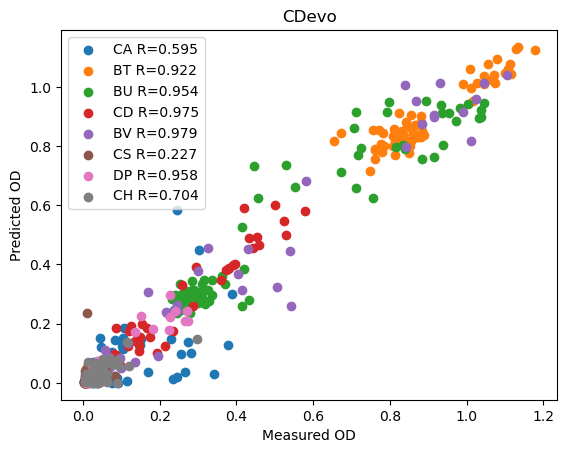

In [5]:
# run kfold for each file 
for file in files:
    strain = file.split("_")[0]
    
    # import data
    df = pd.read_csv(f"data/SET3_Thirdtrial/{file}")
    df.sort_values(by=["Treatments", "Time"], inplace=True)
    
    # make sure that conditions have at least one measurement
    dfs = []
    for treatment, df_t in df.groupby("Treatments"):
        if df_t.shape[0] > 1:
            dfs.append(df_t)
    df = pd.concat(dfs)

    # determine species names 
    species = df.columns.values[2:]

    # separate mono culture data 
    mono_dfs = []
    dfs = []
    treatments = []
    for treatment, df_i in df.groupby("Treatments"):
        # hyphen is only in community conditions
        if "-" in treatment:
            dfs.append(df_i)
            # save treatment name without the replicate identifier 
            treatments.append([treatment.split("_")[0]]*df_i.shape[0])
        else:
            mono_dfs.append(df_i)
    treatments = np.concatenate(treatments)
    unique_treatments = np.unique(treatments)
    mono_df = pd.concat(mono_dfs)
    df = pd.concat(dfs)

    # init kfold object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=21)

    # keep track of all predictions
    all_exp_names = []
    all_pred_species = []
    all_true = []
    all_pred = []

    # run Kfold 
    for kf_idx, (train_index, test_index) in enumerate(kf.split(unique_treatments)):
        
        # get train df
        train_inds = np.in1d(treatments, unique_treatments[train_index])
        train_df = df.iloc[train_inds].copy()
        train_df = pd.concat((mono_df, train_df))
        
        # average replicates in the test_df
        test_df = []
        for test_treatment in unique_treatments[test_index]:
            # pull dataframe with all replicates of same test treatment 
            treatment_inds = np.in1d(treatments, test_treatment)
            df_treatment = df.iloc[treatment_inds].copy()
            
            # get set of unique measurement times
            treatment_times = np.unique(df_treatment.Time.values)
            
            # init dataframe to store averaged values
            avg_df = pd.DataFrame()
            avg_df['Treatments'] = [test_treatment]*len(treatment_times)
            avg_df['Time'] = treatment_times

            avg_data = np.zeros([len(treatment_times), len(species)])
            for i, time in enumerate(treatment_times):
                avg_data[i] = df_treatment.iloc[df_treatment.Time.values==time][species].mean()
            avg_df[species] = avg_data
            test_df.append(avg_df)
        
        # combine averaged dataframes for test dataframe
        test_df = pd.concat(test_df)
        
        # optimize lambda using kfold on training data (nested kfold)
        lmbda = optimize_lmbda(train_df)
        print(f"Strain {strain}, Outer Fold {kf_idx+1}, L1: {lmbda}")
        
        # init model 
        model = gLV(dataframe=train_df, 
                    species=species,
                    lmbda=lmbda)

        # fit to data 
        f = model.fit_rmse(epochs=n_epochs)

        # plot fitness to data
        exp_names, pred_species, true, pred = predict_df(model, test_df, species)

        # append predictions 
        all_exp_names = np.append(all_exp_names, exp_names)
        all_pred_species = np.append(all_pred_species, pred_species)
        all_true = np.append(all_true, true)
        all_pred = np.append(all_pred, pred)

        # save prediction results to a .csv
        kfold_df = pd.DataFrame()
        kfold_df['Treatments'] = all_exp_names
        kfold_df['species'] = all_pred_species
        kfold_df['true'] = all_true
        kfold_df['pred'] = all_pred
        kfold_df.to_csv(f"kfold/{strain}_{n_splits}_fold.csv", index=False)
        
    # show prediction performance of individual species
    for sp in species:
        sp_inds = all_pred_species == sp
        R = linregress(all_true[sp_inds], all_pred[sp_inds]).rvalue
        plt.scatter(all_true[sp_inds], all_pred[sp_inds], label=f"{sp} " + "R={:.3f}".format(R))

    plt.xlabel("Measured OD")
    plt.ylabel("Predicted OD")
    plt.legend()
    plt.title(strain)
    plt.savefig(f"figures/{strain}_{n_splits}_fold.pdf", dpi=300)
    plt.show()